In [1]:
using Pkg

Pkg.activate("../..")

projectdir_static = dirname(Base.active_project())

projectdirx(args...) = joinpath(projectdir_static, args...)

# Generate functions to access the path of default subdirectories.
for dir_type ∈ ("data", "src", "plots", "scripts", "papers")
    function_name = Symbol(dir_type * "dirx")
    @eval begin
        $function_name(args...) = projectdirx($dir_type, args...)
    end
end

using DrWatson

@quickactivate "GRNEvoContingencyAnalysis"

projectname()

  Activating project at `~/Documents/GRNEvoContingency`


  Activating project at `~/Documents/GRNEvoContingency/notebooks`


"GRNEvoContingencyAnalysis"

In [2]:
include(srcdirx("Evolution.jl"))
include(srcdirx("FitnessFunctions.jl"))
include(srcdirx("Visualization.jl"))
include(srcdirx("DynamicalClustering.jl"))
include(srcdirx("DataProcessing.jl"))

exp_name = "RE_Minimal_Inhibiting"

include(srcdirx("ExperimentSetups/Experiment_1/" * exp_name * ".jl"))

using JLD2
using CairoMakie
using ColorSchemes
using BenchmarkTools
using Distances
using StatsPlots
using Clustering
using MultivariateStats
using HypothesisTests
using PyCall
using DecisionTree
using CategoricalArrays
# using ScikitLearn
using ShapML
using DataFrames
using Combinatorics
using GraphMakie
using Graphs
using NetworkLayout
using UMAP
using LinearAlgebra
using UMAP
# using LayeredLayouts

In [3]:
statmod = pyimport("statsmodels.graphics.mosaicplot")

plt = pyimport("matplotlib.pyplot")

pd = pyimport("pandas")

shap = pyimport("shap")

xgboost = pyimport("xgboost");

phate = pyimport("phate");

In [4]:
function cond_save(dir,fig,cond)
    if cond
        CairoMakie.save(dir,fig)
    end
end

function return_order_by_count(v)

    v_un = unique(v)
    counts_v = [count(x->x==value,v) for value in v_un]

    order_v = sortperm(counts_v,rev = true)

    return v_un[order_v],counts_v[order_v]
end

cond = true

true

In [5]:
color_scheme = cgrad(:tab20,categorical = true);

cp = palette([:purple,:red,:green,:yellow,:blue,:pink])

color_name = ["purple","red","green","yellow","blue","pink"]

fund_top_ndict = Dict(t=>n for (n,t) in enumerate(fundamental_topologies));

fund_top_dict = Dict(n=>t for (n,t) in enumerate(fundamental_topologies));

fund_top_dict[0] = "No assignment"

fund_top_ndict["No assignment"] = 0;

fund_top_dict_rv = Dict(j=>i for (i,j) in fund_top_dict);

network_topology_dict = Dict("feed_forward"=>w_feed_forward,"mutual_inh"=>w_mutual_inh,"frozen_osc"=>w_frozen_osc,"overlap_dom"=>w_overlap_dom,"bistable"=>w_bistable,"classical"=>w_classical);

#################################################################

weight_indices = Tuple.(findall(viable_mutations.> 0));

vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

weight_names = [string(vertex_names[last(t)]) * "=>" * string(vertex_names[first(t)]) for t in weight_indices];

ci_indices_dict = Dict(ci=>i for (i,ci) in enumerate(CartesianIndex.(weight_indices)));

In [6]:
data = load(datadirx("exp_pro/Experiment_1/" * exp_name * "_RawData.jld2"));

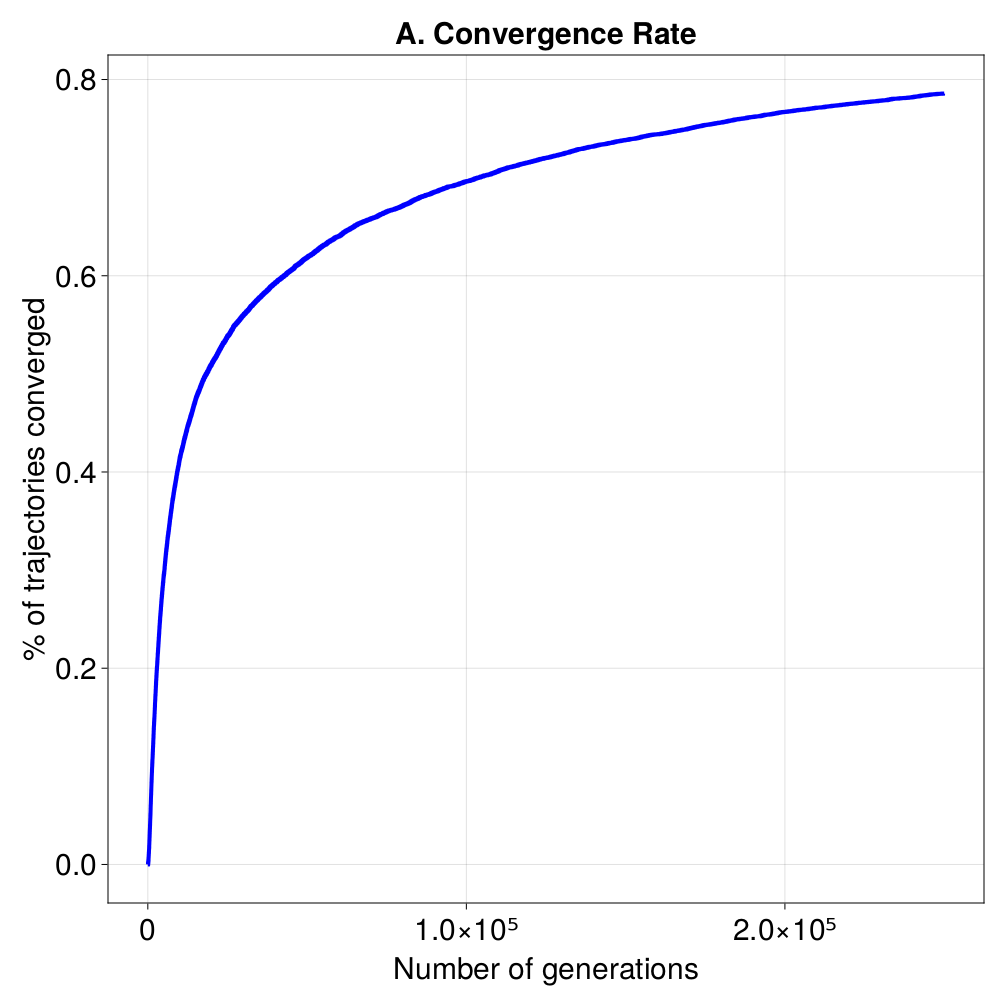

In [7]:
conv = copy(data["converged"]);

nconv = sum(conv)

conv_time = map(x->length(x),data["fitness_traj"])

cum_conv = [sum(conv_time .< i)/n_trials for i in 1:max_gen];

fig = CairoMakie.Figure(resolution = (1000,1000), fontsize = 30.)

ax = Axis(fig[1,1],title = "A. Convergence Rate",xlabel = "Number of generations",ylabel = "% of trajectories converged")

color_scheme = cgrad(:tab10, categorical = true)

CairoMakie.lines!(ax,cum_conv,label = "Grad -> Left -> Stripe",color = :blue,linewidth = 4.)

# save(plotsdirx("Experiment_1/FinalFigures","ConvergenceRates_beta20.png"),fig)

fig

In [8]:
# phate_op = phate.PHATE(knn = 1000,n_jobs = -2,random_state = 999)

# phate_X = reduce(hcat,unique(data["all_networks_dyn_av"])) |> transpose |> collect;

# phate_dyn = phate_op.fit_transform(phate_X);

In [9]:
# adj_matrices = map(w->make_square(Int.(abs.(t))),topologies)
# grn_graphs = map(x->SimpleDiGraph(adj),adj_matrices)

mutable struct Trajectory

    sim_id :: Int64

    geno_traj :: Vector{Vector{Float64}}
    topologies :: Vector{Vector{Int64}}

    n_accepted_mutants :: Int64
    acceptance_ratio :: Float64

    mutation_number :: Vector{Int64}
    stripe_indicator :: Vector{Bool}
    H0 :: Int64
    wait_times :: Vector{Int64}

    fitness_traj :: Vector{Float64}
    top_edits :: Vector{Int64}
    weight_edits :: Any
    masked_hamming_distance_H0 :: Any
    masked_hamming_distance :: Any

    initial_fitness :: Float64
    final_fitness :: Float64
    mutant_info :: Any

    inc_metagraph_vertices :: Any
    inc_metagraph_parents :: Any 
    minimal_stripe_subgraphs :: Any

    parent_inclusion_indicator :: Any

    tt_label_probabilities :: Any
    tt_label_predictions :: Any
    tt_label_entropies :: Any
    tt_prediction_error :: Any

    gt_label_probabilities :: Any
    gt_label_predictions :: Any
    gt_label_entropies :: Any
    gt_prediction_error :: Any

    mss_probabilities :: Any
    mss_predictions :: Any
    mss_entropies :: Any
    mss_prediction_error :: Any

    train_test_indicator :: Any
    train_test_indicator_mss :: Any
    embeddings :: Any
    other :: Any
    
end

function make_square(m::Vector)
    vcat(reshape(m,(3,4)),zeros(typeof(m[1]),(1,4)))
end

function add_fitness(tuple_f)
    return tuple_f[1] + ((tuple_f[2]+1)/2) + 1
end

function compute_cumulative_edits(gt)

    dham = pairwise(Hamming(),gt)

    total_ham = 0

    cumulative_ham = []

    push!(cumulative_ham,total_ham)

    for i in 1:size(gt,2)-1

        total_ham += dham[i,i+1]

        push!(cumulative_ham,total_ham)
    end

    return Int64.(cumulative_ham)

end

function masked_hamming_distance(topology,target_topology)

    new_topology = copy(topology)

    z0 = findall(x->x == 0,target_topology)

    new_topology[z0] .= 0.

    Distances.evaluate(Hamming(),new_topology,target_topology)

end

function group_values_into_bins(values,bins)
    bin_counts = zeros(Int,length(bins)-1)

    new_values = copy(values)

    for i in 1:length(bins)-1
        total = 0.
        for (n,v) in enumerate(new_values)
            if (v < bins[i+1]) && (v >= bins[i])
                total+=1 
                deleteat!(new_values,n)
            end
        end
        bin_counts[i] = total
    end

    return bin_counts
end

uniqueidx(x) = unique(i -> x[:,i], 1:size(x,2))

uniqueid(x) = unique(i -> x[i], 1:length(x))
    

function Trajectory(sim_id::Int64,geno_traj_m::Matrix{Float64},fitness_traj_all::Vector{Tuple{Float64, Float64}},mut_types::Any)

    geno_traj = [collect(i) for i in eachcol(geno_traj_m)]

    ######## process trajectory data

    topologies = map(w->Int.(sign.(w)),geno_traj)
    unique_fitness_traj = unique(fitness_traj_all)

    n_accepted_mutants = length(unique_fitness_traj)-1
    n_generated_mutants = length(fitness_traj_all)-1
    acceptance_ratio = n_accepted_mutants / n_generated_mutants

    mutation_number = [i for i in 0:n_accepted_mutants]
    stripe_indicator =  map(ft->ft[1] == 0,unique_fitness_traj)
    H0 = minimum(findall(stripe_indicator))
    wait_times = unique(i -> fitness_traj_all[i], 1:length(fitness_traj_all))

    fitness_traj = map(ft->add_fitness(ft),unique_fitness_traj)
    top_edits = compute_cumulative_edits(reduce(hcat,topologies))
    weight_edits = nothing 
    masked_hamming_distance_H0 = nothing
    masked_hamming_distance = nothing

    initial_fitness = fitness_traj[1]
    final_fitness = fitness_traj[end]

    ######## MST

    minimal_stripe_subgraphs = nothing 
    metagraph_vertices = nothing
    metagraph_parents = nothing

    ######## generate mutation data

    weight_id = get_mutation_id(geno_traj_m)
    weight_noise = get_mutant_dist(geno_traj_m)

    fitness_delta = get_fitness_delta(fitness_traj)

    n_weight_changes = map(m->length(m),weight_id)

    weight_id_label = map(v->join(map(x->weight_names[x],v),"|"),weight_id)

    start_fitness = fitness_traj[1:end-1]
    start_fitness_tuple = unique_fitness_traj[1:end-1]
    mutant_fitness = fitness_traj[2:end]

    start_network = [collect(v) for v in eachcol(geno_traj_m[:,1:end-1])]

    mutant_info = [(weight_id = weight_id[n],weight_id_label = weight_id_label[n],mut_type = mut_types[n], mut_size = weight_noise[n],start_fitness = start_fitness[n],start_fitness_tuple = start_fitness_tuple[n],mutant_fitness = mutant_fitness[n],fitness_delta = fitness_delta[n],start_network = start_network[n]) for n in 1:length(weight_id)]

    ####### predictions

    parent_inclusion_indicator = nothing

    tt_label_probabilities = nothing
    tt_label_predictions = nothing
    tt_label_entropies = nothing
    tt_prediction_error = nothing

    gt_label_probabilities = nothing
    gt_label_predictions = nothing
    gt_label_entropies = nothing
    gt_prediction_error = nothing

    mss_probabilities = nothing
    mss_predictions = nothing
    mss_entropies = nothing
    mss_prediction_error = nothing

    train_test_indicator = nothing
    train_test_indicator_mss = nothing
    embeddings = nothing
    other = nothing

    ####### instantiate 

    Trajectory(sim_id,geno_traj,topologies,n_accepted_mutants,acceptance_ratio,mutation_number,stripe_indicator,H0,wait_times,fitness_traj,top_edits,weight_edits,masked_hamming_distance_H0,masked_hamming_distance,initial_fitness,final_fitness,mutant_info,metagraph_vertices,metagraph_parents,minimal_stripe_subgraphs,parent_inclusion_indicator,
                                                                                                            tt_label_probabilities,tt_label_predictions,tt_label_entropies,tt_prediction_error,gt_label_probabilities,gt_label_predictions,gt_label_entropies,gt_prediction_error,
                                                                                                            mss_probabilities,mss_predictions,mss_entropies,mss_prediction_error,train_test_indicator,train_test_indicator_mss,embeddings,other)
end


function assign_minimal_subgraphs!(tr::Trajectory,fs,ls)
    tr.minimal_stripe_subgraphs = fill([],length(tr.topologies))
    tr.minimal_stripe_subgraphs[tr.H0] = fs
    tr.minimal_stripe_subgraphs[end] = ls

    tr.masked_hamming_distance_H0 = [[masked_hamming_distance(top,Int.(sign.(fs))) for top in tr.topologies],[masked_hamming_distance(tr.topologies[1],top) for top in tr.topologies]]
    tr.masked_hamming_distance = [[masked_hamming_distance(top,Int.(sign.(ls))) for top in tr.topologies],[masked_hamming_distance(tr.topologies[1],top) for top in tr.topologies]]

end



function create_inclusion_metagraph(trajectories::Vector{Trajectory})

    min_stripe_top = unique(reduce(vcat,[tr.minimal_stripe_subgraphs[[tr.H0,end]] for tr in trajectories]))

    n_min_stripe_top = length(min_stripe_top)

    min_stripe_top_complexity = map(top->sum(abs.(top)),min_stripe_top)

    min_stripe_top_ordered = min_stripe_top[sortperm(min_stripe_top_complexity)]

    vertex_top_map = Dict(n=>top for (n,top) in enumerate(min_stripe_top_ordered));
    vertex_complexity_map = Dict(n=>sum(abs.(top)) for (n,top) in enumerate(min_stripe_top_ordered));
    top_vertex_map = Dict(top=>n for (n,top) in enumerate(min_stripe_top_ordered));

    inclusion_matrix = zeros(Int64,(n_min_stripe_top,n_min_stripe_top))

    for i in 1:n_min_stripe_top
        for j in 1:n_min_stripe_top
            if i != j
                inclusion_matrix[i,j] = test_inclusion(min_stripe_top_ordered[j],min_stripe_top_ordered[i])
            end
        end
    end

    inc_metagraph = SimpleDiGraph(inclusion_matrix)

    return inc_metagraph, vertex_top_map, top_vertex_map, vertex_complexity_map,inclusion_matrix
end

function assign_inc_vertex_ids!(tr::Trajectory,top_vertex_map)
    tr.inc_metagraph_vertices = [n ∈ [tr.H0,length(tr.topologies)] ? top_vertex_map[tr.minimal_stripe_subgraphs[n]] : -1 for n in 1:length(tr.topologies)]
end

function assign_inc_parents!(tr::Trajectory,inclusion_matrix,vertex_complexity_map,minimal_motif_id)

    tr.inc_metagraph_parents = []

    for n in 1:length(tr.topologies)

        if n ∈ [tr.H0,length(tr.topologies)]

            if tr.inc_metagraph_vertices[n] ∈ minimal_motif_id

                push!(tr.inc_metagraph_parents,tr.inc_metagraph_vertices[n])
            else
                options = minimal_motif_id[findall(inclusion_matrix[minimal_motif_id,tr.inc_metagraph_vertices[n]] .== 1)]
                choice = argmax([vertex_complexity_map[v] for v in options])

                push!(tr.inc_metagraph_parents,options[choice])
            end
        else
            push!(tr.inc_metagraph_parents,-1)
        end 
    end
end

function assign_weight_edits!(tr)

    we = vcat([0],map(mi->length(mi[:weight_id]),tr.mutant_info))

    c_we = [sum(we[1:i+1]) for i in 0:length(we)-1]

    tr.weight_edits = c_we
end

function select_minimal_topologies(list_mss)
    if length(list_mss) == 1
        return sign.(list_mss[1][3])
    else
        id = argmax(map(x->x[2],list_mss))
        return sign.(list_mss[id][3])
    end
end

const powerset_topologies = [[bit == '1' ? -1 : bit == '2' ? 0 : 1 for bit in string(i;base = 3,pad = 10)] for i in 0:3^10-1];


In [10]:
min_end_networks = data["min_end_networks"]

min_fs_networks = data["min_fs_networks"];

In [11]:
countmap(map(x->length(x),min_end_networks))

Dict{Int64, Int64} with 3 entries:
  2 => 502
  3 => 16
  1 => 15196

In [12]:
fs_mss =  map(list_mss->select_minimal_topologies(list_mss),min_fs_networks)
ls_mss =  map(list_mss->select_minimal_topologies(list_mss),min_end_networks);

In [13]:
trajectories = map(n->Trajectory(n,data["geno_traj"][conv][n],data["fitness_traj"][conv][n],data["mut_type"][conv][n]),1:nconv);

In [14]:
for (n,tr) in enumerate(trajectories)
    assign_minimal_subgraphs!(tr,fs_mss[n],ls_mss[n])
end

In [15]:
inc_metagraph, vertex_top_map,top_vertex_map,vertex_complexity_map,inclusion_matrix = create_inclusion_metagraph(trajectories);

minimal_motif_id = findall(indegree(inc_metagraph) .== 0);

minimal_motifs = reduce(hcat,[vertex_top_map[vertex_id] for vertex_id in minimal_motif_id]);

In [16]:
for tr in trajectories
    assign_inc_vertex_ids!(tr,top_vertex_map)
    assign_inc_parents!(tr,inclusion_matrix,vertex_complexity_map,minimal_motif_id)
end

In [17]:
end_parents = map(tr->tr.inc_metagraph_vertices[end],trajectories)

sorted_uep,sorted_counts_uep = return_order_by_count(end_parents);

top_n = 5

5

In [18]:
color_scheme = Makie.wong_colors();

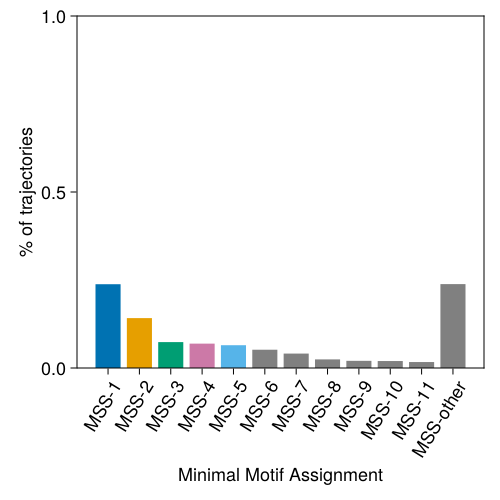

In [19]:
#####################

min_n = 200

fontsize = 18.

color_sorted_counts_uep = [i <= top_n ? color_scheme[i] : :grey for i in 1:length(sorted_counts_uep)]

view_sorted_uep_id = sorted_counts_uep .> min_n

other = sum(sorted_counts_uep[.!view_sorted_uep_id])

n_other = sum(.!view_sorted_uep_id)

n_norm = sum(view_sorted_uep_id)

view_sorted_uep_counts = vcat(sorted_counts_uep[view_sorted_uep_id],[other])

view_color_sorted_counts_uep = vcat(color_sorted_counts_uep[view_sorted_uep_id],[:grey])

axis_label = vcat(collect(string.(1:length(view_sorted_uep_counts)-1)),["other"])

######################

fig = CairoMakie.Figure(resolution = (500,500), fontsize = fontsize)

ax = Axis(fig[1,1], ylabel  = "% of trajectories", xlabel = "Minimal Motif Assignment")

CairoMakie.barplot!(ax,view_sorted_uep_counts ./ sum(view_sorted_uep_counts),color = view_color_sorted_counts_uep)

# CairoMakie.text!(ax,[Point2f(n_norm+0.4,1.2*other/sum(view_sorted_uep_counts))],text = ["# MN-other = " * string(n_other)],fontsize = fontsize)

ax.xticks = (1:length(view_sorted_uep_counts),"MSS-" .* axis_label)

ax.xticklabelrotation = 45.

ax.limits =(nothing,(0.,1.))

CairoMakie.hidedecorations!(ax,label = false,ticklabels = false,ticks = false,minorticks = false)

# save(plotsdirx("Experiment_1/FinalFigures","DistributionOfMotifs.pdf"),fig,pt_per_unit = 1)

fig

In [20]:
uep_position_dict = Dict(v=>n for (n,v) in enumerate(sorted_uep));

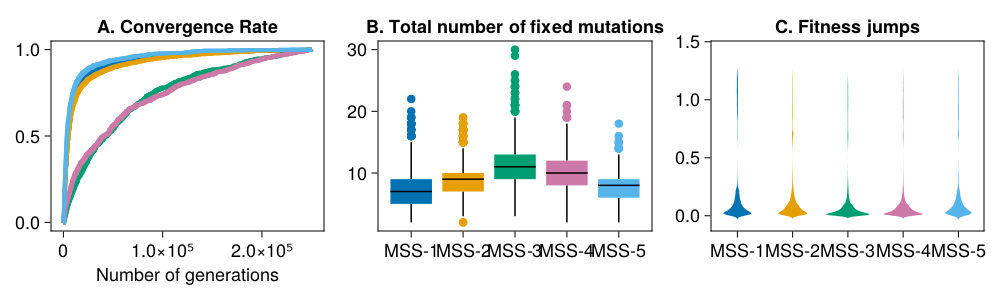

In [21]:
fig = CairoMakie.Figure(resolution = (1000,300), fontsize = 18.)

ax1 = Axis(fig[1,1],title = "A. Convergence Rate",xlabel = "Number of generations")
ax2 = Axis(fig[1,2],title = "B. Total number of fixed mutations")
ax3 = Axis(fig[1,3],title = "C. Fitness jumps")

for (n,parent) in enumerate(sorted_uep[1:top_n])

    tr_data = filter(tr->tr.inc_metagraph_vertices[end] == parent,trajectories)

    nconv = length(tr_data)
 
    conv_time = map(tr->tr.wait_times[end],tr_data)

    cum_conv = [sum(conv_time .< i)/nconv for i in 1:max_gen];

    CairoMakie.lines!(ax1,cum_conv,label = "Grad -> Left -> Stripe",color = color_scheme[n],linewidth = 4.)
    CairoMakie.lines!(ax1,cum_conv,label = "Grad -> Left -> Stripe",color = color_scheme[n],linewidth = 4.)
end

tr_data = filter(tr->tr.inc_metagraph_vertices[end] ∈ sorted_uep[1:5],trajectories)

n_mutants = map(tr->tr.n_accepted_mutants,tr_data)

parents = map(tr->uep_position_dict[tr.inc_metagraph_vertices[end]],tr_data)

grp_colour = map(p->color_scheme[p],parents)

CairoMakie.boxplot!(ax2,parents,n_mutants,color = grp_colour)

ax2.xticks = (1:top_n,["MSS-" * string(n) for n in 1:top_n])

fitness_deltas = map(tr->map(x->x[:fitness_delta],tr.mutant_info),tr_data)

fd_parents = reduce(vcat,[parent.*ones(Int,length(fd)) for (parent,fd) in zip(parents,fitness_deltas)])
fd_colors = map(p->color_scheme[p],fd_parents)
fd_data = reduce(vcat,fitness_deltas)

CairoMakie.violin!(ax3,fd_parents,fd_data,color = fd_colors)

ax3.xticks = (1:top_n,["MSS-" * string(n) for n in 1:top_n])

for ax in [ax1,ax2,ax3]
    CairoMakie.hidedecorations!(ax,label = false,ticklabels = false,ticks = false,minorticks = false)
end

fig

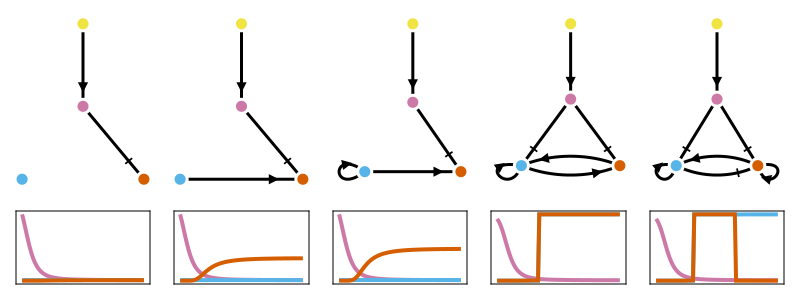

In [22]:
example_mss = 4

tr_data = filter(tr->tr.inc_metagraph_vertices[tr.H0] ∈ sorted_uep[example_mss],trajectories);

tr_choice = 12

tr_traj_id = uniqueid(tr_data[tr_choice].topologies)
tr_traj_id[end] = length(tr_data[tr_choice].topologies)

tr_traj = tr_data[tr_choice].topologies[tr_traj_id]
tr_networks = tr_data[tr_choice].geno_traj[tr_traj_id]

development = DefaultGRNSolver()

tr_phenotypes = [Individual(reshape(net,(3,4)),grn_parameters,development).phenotype.u[end] for net in tr_networks]

n_unique_top = length(tr_traj)

##################

fig = Figure(resolution = (800,300))

node_colors = color_scheme[4:end]

vertex_size = 20
arrow_size = 0.7*vertex_size 
arrow_shift = 0.25
e_width = 0.15*vertex_size
sw = 0.15*vertex_size
selfedge_size = 0.2

vlength = 0.8

scale_angle = 2.9

vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

fixed_layout(_) = [(0.5, 1.), (0.5 - vlength*cos(pi/scale_angle), 1. - vlength*sin(pi/scale_angle)), (0.5 + vlength*cos(pi/scale_angle),1. - vlength*sin(pi/scale_angle)),(0.5,1. + vlength)]

for i in 1:length(tr_phenotypes)

    ax_pheno = Axis(fig[3,i])
    ax_geno = Axis(fig[1:2,i])

    for g in 1:3
        CairoMakie.lines!(ax_pheno,tr_phenotypes[i][g,:],linewidth = 4., color = color_scheme[4:6][g])
    end

    CairoMakie.hidedecorations!(ax_pheno)

    top = reshape(tr_traj[i],(3,4))

    draw_grn_layout!(ax_geno,top,e_width,vertex_size,arrow_size,arrow_shift,sw,fixed_layout,selfedge_size,node_colors,false)

end

fig

In [23]:
all_network_traj_id_v = [[(tr.sim_id,n+1) for (n,_) in enumerate(tr.geno_traj[2:end])] for tr in trajectories]
all_network_id = reduce(vcat,all_network_traj_id_v);

In [24]:
# function assign_embeddings!(trajectories::Vector{Trajectory},all_network_id,all_network_embedding)

#     for tr in trajectories
#         tr.train_test_indicator = fill(zeros(2),length(tr.geno_traj))
#     end

#     for (n,id) in enumerate(all_network_id)
#         trajectories[id[1]].train_test_indicator[id[2]] = all_network_embedding[n,:]
#     end

# end

# assign_embeddings!(trajectories,all_network_id,phate_dyn);

# embedding = reduce(hcat,map(tr->tr.train_test_indicator[end],trajectories))

# traj_mss_id_v = [tr.fitness_traj[2:end] for tr in trajectories]
# traj_mss = reduce(vcat,traj_mss_id_v);

# traj_mss_id_v = [[tr.inc_metagraph_vertices[end] for _ in enumerate(tr.geno_traj[2:end])] for tr in trajectories]
# traj_mss = reduce(vcat,traj_mss_id_v);

# color_traj = [haskey(top_n_dict,i) ? (color_scheme[top_n_dict[i]],0.5) : (:grey,0.5) for i in traj_mss];

# CairoMakie.scatter(phate_dyn,color = color_traj,markersize = 6.)

In [25]:
embedding = umap(data["dmat_av"], 2; metric = :precomputed,n_neighbors = 50,min_dist = 0.5);

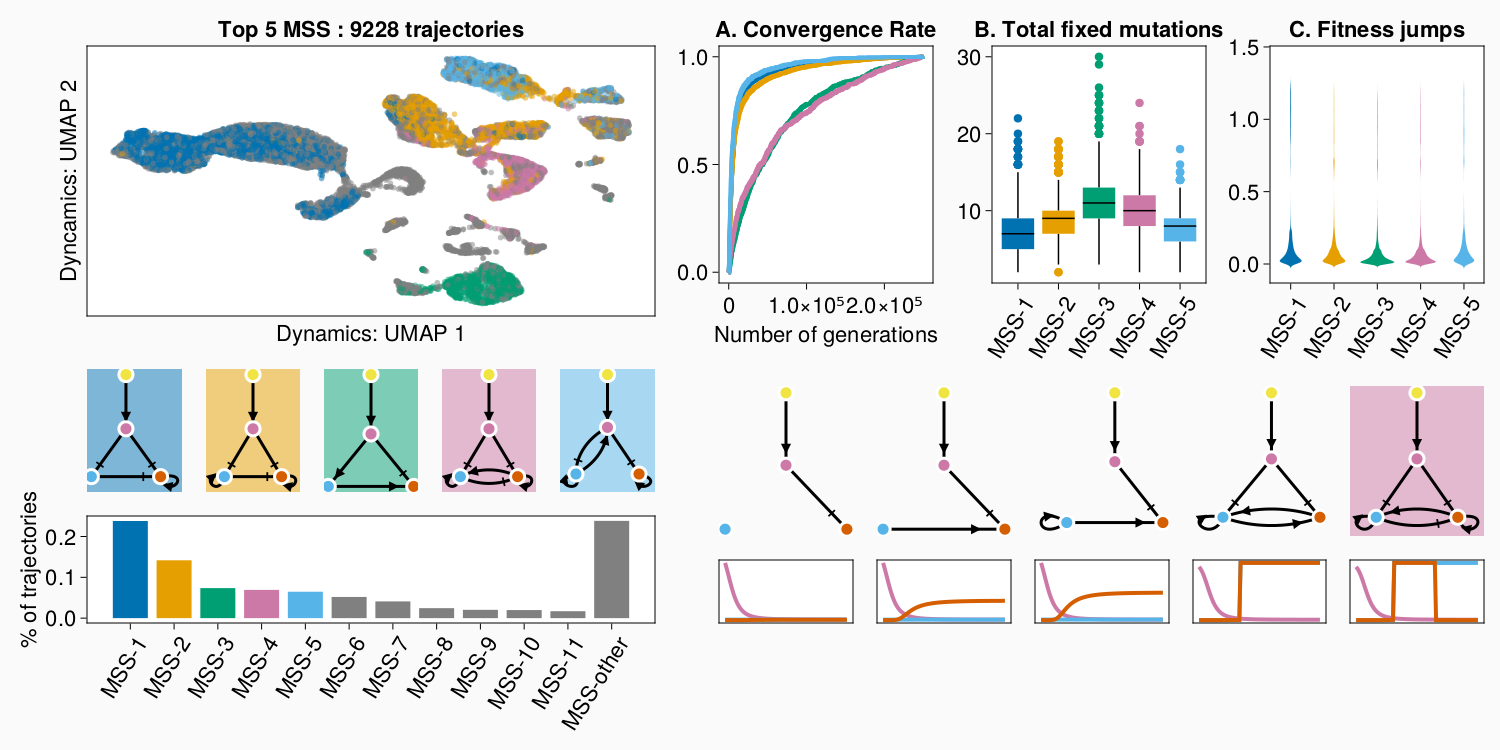

In [26]:
fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (1500, 750),fontsize = 22.)

mo_umap = fig[1:3, 1:3] = GridLayout()
mo = fig[4, 1:3] = GridLayout()
st = fig[1:2, 4:7] = GridLayout()
ex1 = fig[3:4, 4:7] = GridLayout()

n = 5

top_n_dict = Dict(v_id=>pos for (pos,v_id) in enumerate(sorted_uep[1:n]))

ax1 = Axis(mo_umap[1:2,1:n],title = "Top " * string(n) * " MSS : " * string(sum(sorted_counts_uep[1:n])) * " trajectories", xlabel = "Dynamics: UMAP 1", ylabel = "Dyncamics: UMAP 2")

CairoMakie.scatter!(ax1,embedding, color = [haskey(top_n_dict,i) ? (color_scheme[top_n_dict[i]],0.5) : (:grey,0.5) for i in end_parents],markersize = 8.)

hidedecorations!(ax1, label = false)

for i in 1:n

    ax_geno = Axis(mo_umap[3,i], backgroundcolor = (color_scheme[i],0.5))

    top = Int.(reshape(vertex_top_map[sorted_uep[i]],(3,4)))

    draw_grn_layout!(ax_geno,top,e_width,vertex_size,arrow_size,arrow_shift,sw,fixed_layout,selfedge_size,node_colors,false)
end


#######################

ax_mo = Axis(mo[1,1],ylabel  = "% of trajectories")

CairoMakie.barplot!(ax_mo,view_sorted_uep_counts ./ sum(view_sorted_uep_counts),color = view_color_sorted_counts_uep)

# CairoMakie.text!(ax,[Point2f(n_norm+0.4,1.2*other/sum(view_sorted_uep_counts))],text = ["# MN-other = " * string(n_other)],fontsize = fontsize)

ax_mo.xticks = (1:length(view_sorted_uep_counts),"MSS-" .* axis_label)

n_other = sum(.!view_sorted_uep_id)

# ax_mo.xticklabelrotation = 45.

# ax_mo.limits =(nothing,(0.,1.))

ax_mo.xticklabelrotation = 45.

CairoMakie.hidedecorations!(ax_mo,label = false,ticklabels = false,ticks = false,minorticks = false)

###################

ax_st1 = Axis(st[1,1],title = "A. Convergence Rate",xlabel = "Number of generations")
ax_st2 = Axis(st[1,2],title = "B. Total fixed mutations")
ax_st3 = Axis(st[1,3],title = "C. Fitness jumps")

for (n,parent) in enumerate(sorted_uep[1:top_n])

    tr_data = filter(tr->tr.inc_metagraph_vertices[end] == parent,trajectories)

    nconv = length(tr_data)
 
    conv_time = map(tr->tr.wait_times[end],tr_data)

    cum_conv = [sum(conv_time .< i)/nconv for i in 1:max_gen];

    CairoMakie.lines!(ax_st1,cum_conv,color = color_scheme[top_n_dict[parent]],linewidth = 4.)
    CairoMakie.lines!(ax_st1,cum_conv,color = color_scheme[top_n_dict[parent]],linewidth = 4.)
end

CairoMakie.boxplot!(ax_st2,parents,n_mutants,color = grp_colour)

ax_st2.xticks = (1:5,["MSS-1","MSS-2","MSS-3","MSS-4","MSS-5"])
ax_st2.xticklabelrotation = 45.

CairoMakie.violin!(ax_st3,fd_parents,fd_data,color = fd_colors)

ax_st3.xticks = (1:5,["MSS-1","MSS-2","MSS-3","MSS-4","MSS-5"])
ax_st3.xticklabelrotation = 45.

for ax in [ax_st1,ax_st2,ax_st3]
    CairoMakie.hidedecorations!(ax,label = false,ticklabels = false,ticks = false,minorticks = false)
end

####################

for i in 1:length(tr_phenotypes)

    if i >=5
        ax_geno = Axis(ex1[1:2,i], backgroundcolor = (color_scheme[example_mss],0.5))
    else
        ax_geno = Axis(ex1[1:2,i], backgroundcolor = RGBf(0.98, 0.98, 0.98))
    end

    ax_pheno = Axis(ex1[3,i])

    for g in 1:3
        CairoMakie.lines!(ax_pheno,tr_phenotypes[i][g,:],linewidth = 4., color = color_scheme[4:6][g])
    end

    CairoMakie.hidedecorations!(ax_pheno)

    top = reshape(tr_traj[i],(3,4))

    draw_grn_layout!(ax_geno,top,e_width,vertex_size,arrow_size,arrow_shift,sw,fixed_layout,selfedge_size,node_colors,false)

end

# colsize!(fig.layout, 1, Auto(0.5))

# save(plotsdirx("Experiment_1/FinalFigures_MSS","Fig2_beta_20.pdf"),fig,pt_per_unit = 1)

fig

In [27]:
trajectories_p = filter(tr->tr.inc_metagraph_vertices[end] ∈ sorted_uep[1:top_n],trajectories);

In [28]:
function v_restricted_cumulative_wait_time(tr::Trajectory,restriction,restriction_measure)
    id = maximum(findall(restriction_measure(tr,restriction)))

    return sum(tr.wait_times[1:id])
end

function cumulative_wait_time(tr::Trajectory)

    # return [sum(tr.wait_times[1:tr.H0-1])/(tr.H0-1);sum(tr.wait_times[tr.H0]);sum(tr.wait_times[tr.H0+1:end])/(length(tr.wait_times)-tr.H0-1)]

    a = tr.wait_times[1:tr.H0-1]
    b = tr.wait_times[tr.H0]
    c = tr.wait_times[tr.H0+1:end]

    if length(c) == 0 
        return [sum(a)/length(a);sum(b)/length(b);0]
    else
        return [sum(a)/length(a);sum(b)/length(b);sum(c)/length(c)]
    end
    
end


function fitness_restriction_measure(tr,restriction)
    tr.fitness_traj  .<= restriction
end

fitness_restriction_measure (generic function with 1 method)

In [29]:
all_wait_times = reduce(hcat,[cumulative_wait_time(tr) for tr in trajectories_p]);

In [30]:
function evaluate_epistasis_class(mut_tuple,grn_parameters,development,fitness_function)

    n_mut = length(mut_tuple[:weight_id])

    if n_mut > 1

        mut_combi = [[bit == '1' ? true : false for bit in string(i;base = 2,pad = n_mut)] for i in 1:2^n_mut-1]

        accept_new_mutant = []

        for mut_id in mut_combi[1:end-1]

            new_network = noise_specified(mut_tuple[:start_network],mut_tuple[:weight_id][mut_id],mut_tuple[:mut_size][mut_id],mut_tuple[:mut_type][mut_id])

            mutant = Individual(reshape(new_network,(3,4)),grn_parameters,development)

            mutant_fitness = fitness_function(mutant.phenotype)

            fix_p = fixation_probability(mutant_fitness[1] - mut_tuple[:start_fitness_tuple][1],mutant_fitness[2] - mut_tuple[:start_fitness_tuple][2],β)

            push!(accept_new_mutant,fix_p > 0)

        end

        rtype = :ne

        if !any(accept_new_mutant)
            rtype = :rse

        else
            for mut_id in 1:n_mut
                accept_id = findall(x->x[mut_id],mut_combi[1:end-1])
                if any([!x for x in accept_new_mutant[accept_id]])
                    rtype = :se
                end
            end
        end
    else
        rtype = :sm
    end

    return rtype
end

function calculate_epi_class_proportion(epi_class)
    
    total = length(epi_class)

    return [count(x->x==ec,epi_class)/total for ec in [:rse,:se,:ne,:sm]]
end

function calculate_epi_class_proportion(epi_class,epi_class_totals)
    
    return [count(x->x==ec,epi_class) for ec in [:rse,:se,:ne,:sm]] ./ epi_class_totals
end

function evaluate_epistasis_types!(tr,grn_parameters,development,fitness_function)

    all_class_epi = map(mi->evaluate_epistasis_class(mi,grn_parameters,development,fitness_function),tr.mutant_info);

    tr.other = all_class_epi

end

function get_mut_size_by_type(tr,type,range_l,range_u)

    all_type = []

    for mi in tr.mutant_info[range_l:range_u]

        mi_id = findall(x->x==type,mi.mut_type)

        if length(mi_id) >= 1
            push!(all_type,mi[:mut_size][mi_id])
        end

    end

    if length(all_type) > 0

        return reduce(vcat,all_type)
    else
        return []
    end

end

function get_mut_type(tr,range_l,range_u)

    d= [mi[:mut_type] for mi in tr.mutant_info[range_l:range_u]]

    if length(d) >= 1
        return reduce(vcat,d)
    end

end

function get_mut_n(tr,range_l,range_u)

    d = [length(mi[:weight_id]) for mi in tr.mutant_info[range_l:range_u]]

    if length(d) >= 1
        return reduce(vcat,d)
    end

end

function calculate_mut_type_proportion(mut_type,types)
    
    total = length(mut_type)

    return [count(x->x==ec,mut_type)/total for ec in types]
end

function calculate_mut_type_count(mut_type,types)

    return [count(x->x==ec,mut_type) for ec in types]
end




calculate_mut_type_count (generic function with 1 method)

In [31]:
for tr in trajectories_p
    evaluate_epistasis_types!(tr,grn_parameters,DefaultGRNSolver(),fitness_function)
end

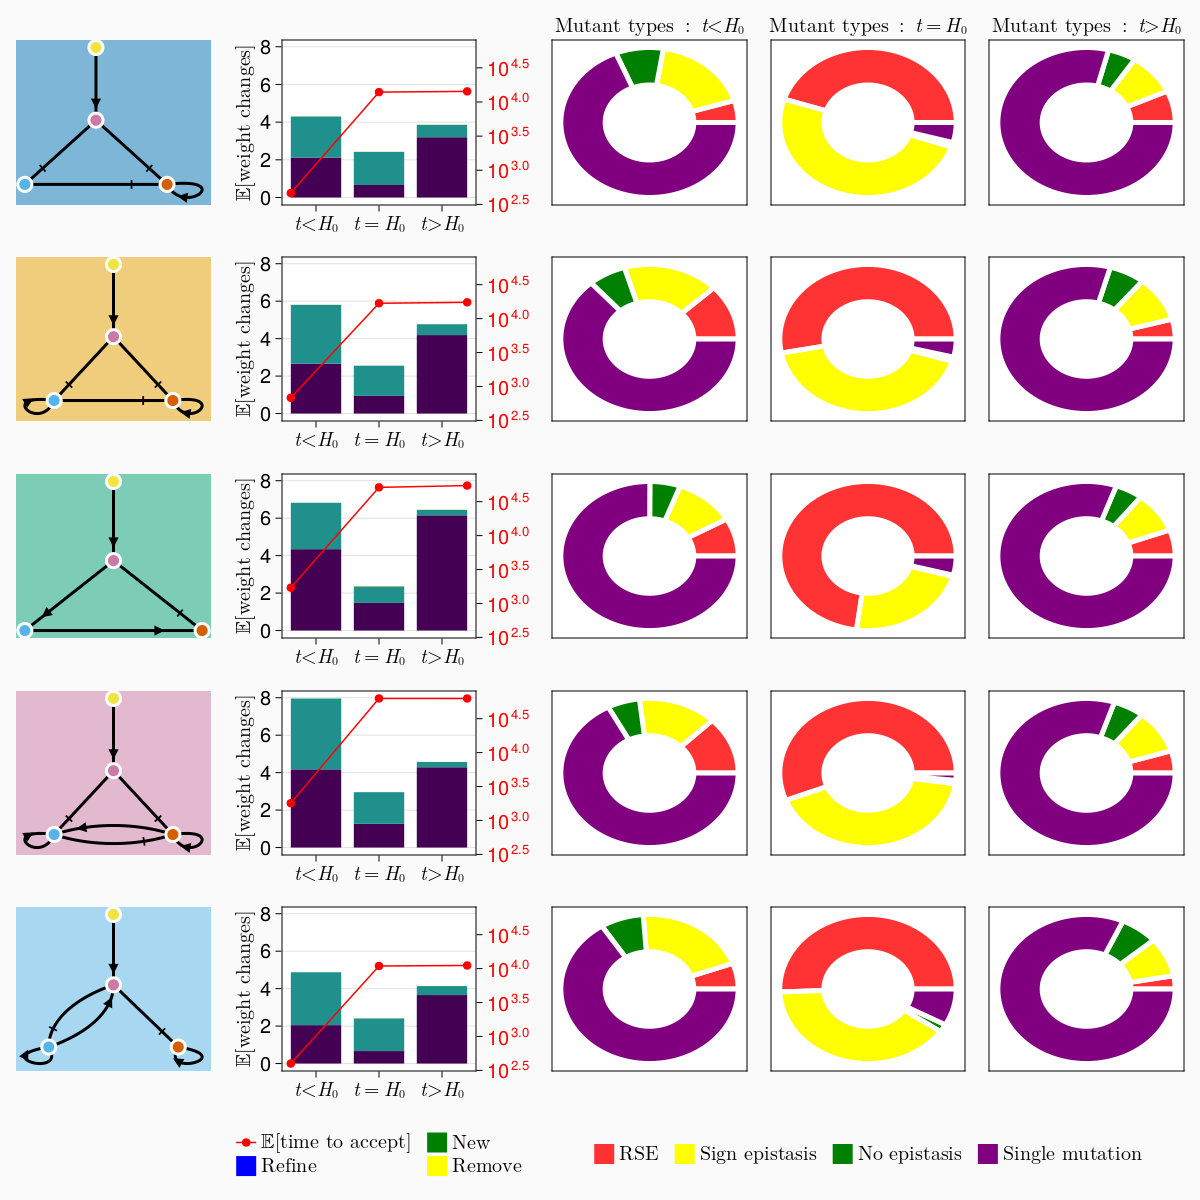

In [32]:
fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (1200, 1200),fontsize = 20.)

colors = [(:red,0.8), :yellow, :green, :purple]

ax_wait_list = []

scale = 10^4

name = L"(10^4)"

ax_wait_list = []
ax_wait_2_list = []

wt_l_list = []
wt_s_list = []

for n in 1:top_n

    ax_geno = Axis(fig[n,1],backgroundcolor = (color_scheme[n],0.5))

    top = Int.(reshape(vertex_top_map[sorted_uep[n]],(3,4)))

    draw_grn_layout!(ax_geno,top,e_width,vertex_size,arrow_size,arrow_shift,sw,fixed_layout,selfedge_size,node_colors,false)

    if n == 1
        ax_wait = Axis(fig[n,2],ylabel = L"\mathbb{E}[\text{weight changes}]")
    else
        ax_wait = Axis(fig[n,2],ylabel = L"\mathbb{E}[\text{weight changes}]")
    end

    ax_wait_2 = Axis(fig[n, 2], yticklabelcolor = :red, yaxisposition = :right,yscale = log10)

    hidespines!(ax_wait_2 )
    hideydecorations!(ax_wait_2,label = false,ticklabels = false,ticks = false,minorticks = false)
    hidexdecorations!(ax_wait_2)

    #############################

    mut_type_prop_all = []
    mut_type_time_labels = []
    mut_type_labels = []

    # mut_type_prop = map(tr->calculate_mut_type_proportion(get_mut_type(tr,1,tr.H0-2), [:existing,:new,:del]),filter(tr->(tr.inc_metagraph_vertices[end] == sorted_uep[n]) & (tr.H0-2 > 0),trajectories_p))

    mut_type_prop = map(tr->calculate_mut_type_count(get_mut_type(tr,1,tr.H0-2), [:existing,:new,:del]),filter(tr->(tr.inc_metagraph_vertices[end] == sorted_uep[n]) & (tr.H0-2 > 0),trajectories_p))

    mut_type_prop_av = mean(reduce(hcat,mut_type_prop),dims = 2)[:,1]

    push!(mut_type_prop_all,mut_type_prop_av)
    push!(mut_type_labels, [1,2,3])
    push!(mut_type_time_labels,[1,1,1])

    # mut_type_prop = map(tr->calculate_mut_type_proportion(get_mut_type(tr,tr.H0-1,tr.H0-1), [:existing,:new,:del]),filter(tr->tr.inc_metagraph_vertices[end] == sorted_uep[n] ,trajectories_p))
    mut_type_prop = map(tr->calculate_mut_type_count(get_mut_type(tr,tr.H0-1,tr.H0-1), [:existing,:new,:del]),filter(tr->tr.inc_metagraph_vertices[end] == sorted_uep[n] ,trajectories_p))

    mut_type_prop_av = mean(reduce(hcat,mut_type_prop),dims = 2)[:,1]

    push!(mut_type_prop_all,mut_type_prop_av)
    push!(mut_type_labels, [1,2,3])
    push!(mut_type_time_labels,[2,2,2])

    # mut_type_prop = map(tr->calculate_mut_type_proportion(get_mut_type(tr,tr.H0,length(tr.topologies)-1), [:existing,:new,:del]),filter(tr->(tr.inc_metagraph_vertices[end] == sorted_uep[n])  & (tr.H0 < length(tr.topologies)),trajectories_p))

    mut_type_prop = map(tr->calculate_mut_type_count(get_mut_type(tr,tr.H0,length(tr.topologies)-1), [:existing,:new,:del]),filter(tr->(tr.inc_metagraph_vertices[end] == sorted_uep[n])  & (tr.H0 < length(tr.topologies)),trajectories_p))

    mut_type_prop_av = mean(reduce(hcat,mut_type_prop),dims = 2)[:,1]

    push!(mut_type_prop_all,mut_type_prop_av)
    push!(mut_type_labels, [1,2,3])
    push!(mut_type_time_labels,[3,3,3])

    mut_type_prop_all = reduce(vcat,mut_type_prop_all)
    mut_type_time_labels = reduce(vcat,mut_type_time_labels)
    mut_type_labels = reduce(vcat,mut_type_labels); 

    CairoMakie.barplot!(ax_wait,mut_type_time_labels,mut_type_prop_all,stack = mut_type_labels,color = mut_type_labels)

    ax_wait.xticks = (1:3,[L"t<H_{0}",L"t=H_{0}",L"t>H_{0}" ])
    
    #format y ticks to latex numbers

    CairoMakie.hidexdecorations!(ax_wait,label = false,ticklabels = false,ticks = false,minorticks = false)
    CairoMakie.hideydecorations!(ax_wait,label = false,ticklabels = false,ticks = false,minorticks = false,grid = false)

    push!(ax_wait_list,ax_wait)

    ############################

    mean_wait = mean(all_wait_times[:,findall(tr->tr.inc_metagraph_vertices[end] == sorted_uep[n],trajectories_p)],dims = 2)[:,1]
    mean_wait_v = reduce(vcat,mean_wait)

    # mean_wait_v = log.(reduce(vcat,mean_wait))

    mean_wait_type_labels = [1,2,3]

    wt_l = CairoMakie.lines!(ax_wait_2,mean_wait_type_labels,mean_wait_v,color = :red)
    wt_s = CairoMakie.scatter!(ax_wait_2,mean_wait_type_labels,mean_wait_v,color = :red)

    push!(ax_wait_2_list,ax_wait_2)

    push!(wt_l_list,wt_l)
    push!(wt_s_list,wt_s)

    #############################

    if n == 1
        ax_epi_lH0 = Axis(fig[n,3],title = L"\text{Mutant types : } t<H_{0}")
    else
        ax_epi_lH0 = Axis(fig[n,3])
    end

    epi_counts = reduce(vcat,map(tr->tr.other[1:tr.H0-2],filter(tr->tr.inc_metagraph_vertices[end] == sorted_uep[n],trajectories_p)))

    epi_counts_prop = calculate_epi_class_proportion(epi_counts)

    CairoMakie.pie!(ax_epi_lH0,epi_counts_prop,radius = 4,color = colors,
    inner_radius = 2,
    strokecolor = :white,
    strokewidth = 5)

    CairoMakie.hidedecorations!(ax_epi_lH0)

    if n == 1
        ax_epi_H0 = Axis(fig[n,4],title = L"\text{Mutant types : } t=H_{0}")
    else
        ax_epi_H0 = Axis(fig[n,4])
    end

    epi_counts = map(tr->tr.other[tr.H0-1],filter(tr->tr.inc_metagraph_vertices[end] == sorted_uep[n],trajectories_p))

    epi_counts_prop = calculate_epi_class_proportion(epi_counts)

    CairoMakie.pie!(ax_epi_H0,epi_counts_prop,radius = 4,color = colors,
    inner_radius = 2,
    strokecolor = :white,
    strokewidth = 5)

    CairoMakie.hidedecorations!(ax_epi_H0)

    if n == 1
        ax_epi_uH0 = Axis(fig[n,5],title = L"\text{Mutant types : } t>H_{0}")
    else
        ax_epi_uH0 = Axis(fig[n,5])
    end

    epi_counts = reduce(vcat,map(tr->tr.other[tr.H0:end],filter(tr->tr.inc_metagraph_vertices[end] == sorted_uep[n],trajectories_p)))

    epi_counts_prop = calculate_epi_class_proportion(epi_counts)

    CairoMakie.pie!(ax_epi_uH0,epi_counts_prop,radius = 4,color = colors,
    inner_radius = 2,
    strokecolor = :white,
    strokewidth = 5)

    CairoMakie.hidedecorations!(ax_epi_uH0)

end

labels = [L"\text{RSE}",L"\text{Sign epistasis}",L"\text{No epistasis}",L"\text{Single mutation}"]

Legend(fig[top_n+1, 3:5], [PolyElement(color=c) for c in colors], labels, framevisible=false,orientation = :horizontal)

colors = [:blue,:green, :yellow]

Legend(fig[top_n+1, 2],
    vcat([[wt_s_list[1], wt_l_list[1]]],[PolyElement(color=c) for c in colors]),
    vcat([L"\mathbb{E}[\text{time to accept}]"],[L"\text{Refine}",L"\text{New}",L"\text{Remove}"]),framevisible=false,nbanks = 2,orientation = :horizontal)

# labels = [L"\text{Refine}",L"\text{New}",L"\text{Remove}"]

# colors = [:blue,:green, :yellow]

# Legend(fig[top_n+2, 2], [PolyElement(color=c) for c in colors], labels, framevisible=false)

# Legend(fig[top_n+1, 2],
# [[wt_s_list[1], wt_l_list[1]]],
# [L"\mathbb{E}[\text{time to accept}]",L"\text{Refinement}",L"\text{New}",L"\text{Delete}"],orientation = :horizontal)


linkyaxes!(ax_wait_list...)
linkyaxes!(ax_wait_2_list...)


fig


In [33]:
# #VIM analysis => in what cases is it linked to SE, in the sense that if we remove the hitchhiker, does it constrain the future as much (delta entropy for hitchhiker removal)?

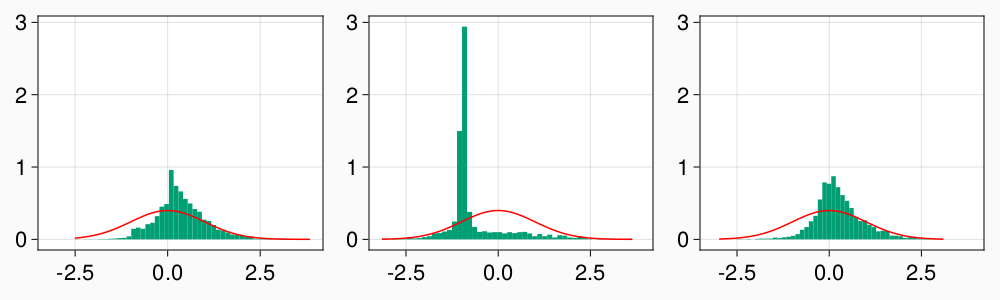

In [34]:
mut_noise_dist = Normal(0.0,noise_cv);
norm_pdf = [pdf(mut_noise_dist,t) for t in LinRange(-2.5,2.5,100)];

fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (1000, 300),fontsize = 22.)

type = :existing
bins = 50
n = 3

if type == :existing
    mut_noise_dist = Normal(0.0,noise_cv);
else
    mut_noise_dist = Uniform(-max_w,max_w);
end

mut_size = reduce(vcat,map(tr->get_mut_size_by_type(tr,type,1,tr.H0-2),filter(tr->tr.inc_metagraph_vertices[end] == sorted_uep[n],trajectories_p)))

pv1 = pvalue(OneSampleADTest(Float64.(mut_size),mut_noise_dist))

ax1 = Axis(fig[1,1])

CairoMakie.hist!(ax1,mut_size,bins = bins,normalization = :pdf,color = color_scheme[n])

min_t = minimum(mut_size)
max_t = maximum(mut_size)

norm_pdf = [pdf(mut_noise_dist,t) for t in LinRange(min_t,max_t,100)];

CairoMakie.lines!(ax1,LinRange(min_t,max_t,100),norm_pdf,color = :red)

mut_size = reduce(vcat,map(tr->get_mut_size_by_type(tr,type,tr.H0-1,tr.H0-1),filter(tr->tr.inc_metagraph_vertices[end] == sorted_uep[n],trajectories_p)))

pv2 = pvalue(OneSampleADTest(Float64.(mut_size),mut_noise_dist))

ax2 = Axis(fig[1,2])

min_t = minimum(mut_size)
max_t = maximum(mut_size)

norm_pdf = [pdf(mut_noise_dist,t) for t in LinRange(min_t,max_t,100)];

CairoMakie.hist!(ax2,mut_size,bins = bins,normalization = :pdf,color = color_scheme[n])
CairoMakie.lines!(ax2,LinRange(min_t,max_t,100),norm_pdf,color = :red)

mut_size = reduce(vcat,map(tr->get_mut_size_by_type(tr,type,tr.H0+1,length(tr.geno_traj)-1),filter(tr->tr.inc_metagraph_vertices[end] == sorted_uep[n],trajectories_p)))

pv3 = pvalue(OneSampleADTest(Float64.(mut_size),mut_noise_dist))

ax3 = Axis(fig[1,3])

min_t = minimum(mut_size)
max_t = maximum(mut_size)

norm_pdf = [pdf(mut_noise_dist,t) for t in LinRange(min_t,max_t,100)];

CairoMakie.hist!(ax3,mut_size,bins = bins,normalization = :pdf,color = color_scheme[n])
CairoMakie.lines!(ax3,LinRange(min_t,max_t,100),norm_pdf,color = :red)

linkxaxes!([ax1,ax2,ax3]...)
linkyaxes!([ax1,ax2,ax3]...)

fig

In [35]:
# fd_pairs = reduce(vcat,[[(mi[:start_fitness],mi[:fitness_delta]) for mi in tr.mutant_info] for tr in trajectories_p]);
# fd_labels = reduce(vcat,[[uep_position_dict[tr.inc_metagraph_vertices[end]] for _ in 1:length(tr.mutant_info)] for tr in trajectories_p]);

# CairoMakie.scatter(fd_pairs,color = [(color_scheme[i],0.5) for i in fd_labels], markersize = 5.)

In [36]:
function create_train_test_split(X,y,train_test_split = 0.8)

    y_sample_id = [shuffle(findall(x->x==label,y)) for label in unique(y)]

    n_train_id = [Int(floor(train_test_split*length(y_sid))) for y_sid in y_sample_id]

    y_train_id = [y_sid[1:n_train] for (y_sid,n_train) in zip(y_sample_id,n_train_id)]

    y_test_id = [y_sid[n_train+1:end] for (y_sid,n_train) in zip(y_sample_id,n_train_id)]

    train_id = reduce(vcat,y_train_id )
    test_id = reduce(vcat,y_test_id )

    X_train = X[train_id,:]
    X_test = X[test_id,:]

    y_train = y[train_id]
    y_test = y[test_id]

    return X_train,X_test,y_train,y_test, train_id, test_id

end

function create_train_test_split_multilabel(X,y,train_test_split = 0.8)

    y_sample_id = [shuffle(findall(mapslices(row->row==label,y,dims = 2)[:,1])) for label in unique(eachrow(y))];

    n_train_id = [Int(floor(train_test_split*length(y_sid))) for y_sid in y_sample_id]

    y_train_id = [y_sid[1:n_train] for (y_sid,n_train) in zip(y_sample_id,n_train_id)]

    y_test_id = [y_sid[n_train+1:end] for (y_sid,n_train) in zip(y_sample_id,n_train_id)]

    train_id = reduce(vcat,y_train_id )
    test_id = reduce(vcat,y_test_id )

    X_train = X[train_id,:]
    X_test = X[test_id,:]

    y_train = y[train_id,:]
    y_test = y[test_id,:]

    return X_train,X_test,y_train,y_test, train_id, test_id

end

function create_train_test_id_split(y,train_test_split = 0.8)

    y_sample_id = [shuffle(findall(x->x==label,y)) for label in unique(y)]

    n_train_id = [Int(floor(train_test_split*length(y_sid))) for y_sid in y_sample_id]

    y_train_id = [y_sid[1:n_train] for (y_sid,n_train) in zip(y_sample_id,n_train_id)]

    y_test_id = [y_sid[n_train+1:end] for (y_sid,n_train) in zip(y_sample_id,n_train_id)]

    train_id = reduce(vcat,y_train_id )
    test_id = reduce(vcat,y_test_id )

    return train_id, test_id

end

function create_train_test_id_split_multilabel(y,train_test_split = 0.8)

    y_sample_id = [shuffle(findall(mapslices(row->row==label,y,dims = 2)[:,1])) for label in unique(eachrow(y))];

    n_train_id = [Int(floor(train_test_split*length(y_sid))) for y_sid in y_sample_id]

    y_train_id = [y_sid[1:n_train] for (y_sid,n_train) in zip(y_sample_id,n_train_id)]

    y_test_id = [y_sid[n_train+1:end] for (y_sid,n_train) in zip(y_sample_id,n_train_id)]

    train_id = reduce(vcat,y_train_id )
    test_id = reduce(vcat,y_test_id )

    return train_id, test_id

end


create_train_test_id_split_multilabel (generic function with 2 methods)

In [37]:
predict_id = sorted_uep[1:top_n]

label_names = [1,2,3,4,5]

trajectories_p = filter(tr->tr.inc_metagraph_vertices[tr.H0] ∈ predict_id,trajectories);

vertex_to_predict_label = Dict(vertex=>n for (n,vertex) in enumerate(predict_id))

predict_label_to_vertex = Dict(n=>vertex for (n,vertex) in enumerate(predict_id))

label = map(tr->vertex_to_predict_label[tr.inc_metagraph_vertices[tr.H0]],trajectories_p);

label_mss = reduce(hcat,map(tr->tr.minimal_stripe_subgraphs[tr.H0],trajectories_p)) |> transpose |> collect;

label_mss_all = reduce(hcat,map(tr->tr.minimal_stripe_subgraphs[tr.H0],trajectories)) |> transpose |> collect;

In [38]:
# train_id,test_id =  create_train_test_id_split(label,0.8);
# save("train_test_ids.jld2", Dict("train" => train_id, "test" => test_id))

# train_id_mss,test_id_mss = create_train_test_id_split_multilabel(label_mss,0.8);

# save("train_test_ids_mss.jld2", Dict("train" => train_id_mss, "test" => test_id_mss))

# train_id_mss_all,test_id_mss_all = create_train_test_id_split_multilabel(label_mss_all,0.8);

# save("train_test_ids_mss_all.jld2", Dict("train" => train_id_mss_all, "test" => test_id_mss_all))

In [39]:
train_id = load("train_test_ids.jld2", "train")
test_id = load("train_test_ids.jld2", "test");

train_id_mss = load("train_test_ids_mss.jld2", "train")
test_id_mss  = load("train_test_ids_mss.jld2", "test");

train_id_mss_all = load("train_test_ids_mss_all.jld2", "train")
test_id_mss_all  = load("train_test_ids_mss_all.jld2", "test");

In [50]:
X_train_ttl_v = [reduce(hcat,unique([vcat(features,label) for features in tr.topologies[1:tr.H0-1]])) for (label,tr) in zip(label[train_id],trajectories_p[train_id])]
X_train_ttl = reduce(hcat,X_train_ttl_v) |> transpose |> collect

y_train_ttl = copy(Int.(X_train_ttl[:,13]))

X_train_gtl_v = [reduce(hcat,[vcat(features,label) for features in tr.geno_traj[1:tr.H0-1]]) for (label,tr) in zip(label[train_id],trajectories_p[train_id])]
X_train_gtl  = reduce(hcat,X_train_gtl_v) |> transpose |> collect;

y_train_gtl = copy(Int.(X_train_gtl[:,13]))

X_train_mss_v = [reduce(hcat,[vcat(features,tr.minimal_stripe_subgraphs[tr.H0]) for features in tr.geno_traj]) for tr in trajectories_p[train_id_mss]]
X_train_mss = reduce(hcat,X_train_mss_v) |> transpose |> collect;

y_train_mss = copy(Int.(X_train_mss[:,13:end-2]))

###################

X_test_ttl_v = [reduce(hcat,unique([vcat(features,label) for features in tr.topologies[1:tr.H0-1]])) for (label,tr) in zip(label[test_id],trajectories_p[test_id])]
X_test_ttl = reduce(hcat,X_test_ttl_v) |> transpose |> collect

y_test_ttl = copy(Int.(X_test_ttl[:,13]))

X_test_gtl_v = [reduce(hcat,[vcat(features,label) for features in tr.geno_traj[1:tr.H0-1]]) for (label,tr) in zip(label[test_id],trajectories_p[test_id])]
X_test_gtl  = reduce(hcat,X_test_gtl_v) |> transpose |> collect;

y_test_gtl = copy(Int.(X_test_gtl[:,13]))

X_test_mss_v = [reduce(hcat,[vcat(features,tr.minimal_stripe_subgraphs[tr.H0]) for features in tr.geno_traj]) for tr in trajectories_p[test_id_mss]]
X_test_mss = reduce(hcat,X_test_mss_v) |> transpose |> collect;

y_test_mss = copy(Int.(X_test_mss[:,13:end-2]));

###################

X_train_mss_v_all = [reduce(hcat,[vcat(features,tr.minimal_stripe_subgraphs[tr.H0]) for features in tr.geno_traj]) for tr in trajectories[train_id_mss_all]]
X_train_mss_all = reduce(hcat,X_train_mss_v_all) |> transpose |> collect;

y_train_mss_all = copy(Int.(X_train_mss_all[:,13:end-2]))

X_test_mss_v_all = [reduce(hcat,[vcat(features,tr.minimal_stripe_subgraphs[tr.H0]) for features in tr.geno_traj]) for tr in trajectories[test_id_mss_all]]
X_test_mss_all = reduce(hcat,X_test_mss_v_all) |> transpose |> collect;

y_test_mss_all = copy(Int.(X_test_mss_all[:,13:end-2]));

In [41]:
for id in train_id
    trajectories_p[id].train_test_indicator = :train
end

for id in test_id
    trajectories_p[id].train_test_indicator = :test
end

for id in train_id_mss
    trajectories_p[id].train_test_indicator_mss  = :train
end

for id in test_id_mss
    trajectories_p[id].train_test_indicator_mss  = :test
end

for id in train_id_mss_all
    trajectories[id].train_test_indicator_mss  = :train
end

for id in test_id_mss_all
    trajectories[id].train_test_indicator_mss  = :test
end

In [67]:
const c_types = ["c" for _ in 1:10];

In [42]:
# class_counts_train = [count(v->v==var,y_train_ttl) for var in label_names]
# class_weights_train = minimum(class_counts_train) ./ class_counts_train
# class_weight_train_instances = map(x->class_weights_train[x],y_train_ttl);

# c_types = ["c" for _ in 1:10];

# d_train_ttl = xgboost.DMatrix(X_train_ttl[:,1:10], label=y_train_ttl .- 1,feature_types = c_types, feature_names = weight_names, weight = class_weight_train_instances)
# d_test_ttl = xgboost.DMatrix(X_test_ttl[:,1:10], label=y_test_ttl .- 1,feature_types = c_types, feature_names = weight_names)

# params = Dict(
#     "eta"=> 0.01,
#     "objective"=>"multi:softprob",
#     "num_class"=>top_n,
#     "subsample"=> 0.5,
#     "eval_metric"=>"auc"
# )

# model_ttl = xgboost.train(params, d_train_ttl, 5000, evals = [(d_test_ttl, "test")], verbose_eval=false, early_stopping_rounds=200)

# y_pred_train_ttl = mapslices(x->argmax(x),model_ttl.predict(d_train_ttl),dims = 2)
# y_pred_test_ttl = mapslices(x->argmax(x),model_ttl.predict(d_test_ttl),dims = 2);

# print(sum(y_pred_test_ttl .== y_test_ttl) / length(y_test_ttl))

# model_ttl.save_model("ModelTTL.json")

In [43]:
model_ttl = xgboost.Booster()
model_ttl.load_model("ModelTTL.json")

In [44]:
# class_counts_train = [count(v->v==var,y_train_gtl) for var in label_names]
# class_weights_train = minimum(class_counts_train) ./ class_counts_train
# class_weight_train_instances = map(x->class_weights_train[x],y_train_gtl);

# d_train_gtl = xgboost.DMatrix(X_train_gtl[:,1:10], label=y_train_gtl .- 1,feature_names = weight_names, weight = class_weight_train_instances)
# d_test_gtl = xgboost.DMatrix(X_test_gtl[:,1:10], label=y_test_gtl .- 1,feature_names = weight_names)

# params = Dict(
#     "eta"=> 0.01,
#     "objective"=>"multi:softprob",
#     "num_class"=>top_n,
#     "subsample"=> 0.5,
#     "eval_metric"=>"auc"
# )

# model_gtl = xgboost.train(params, d_train_gtl, 5000, evals = [(d_test_gtl, "test")], verbose_eval=false, early_stopping_rounds=200)

# y_pred_train_gtl = mapslices(x->argmax(x),model_gtl.predict(d_train_gtl),dims = 2)
# y_pred_test_gtl = mapslices(x->argmax(x),model_gtl.predict(d_test_gtl),dims = 2);

# print(sum(y_pred_test_gtl .== y_test_gtl) / length(y_test_gtl))

# model_gtl.save_model("ModelGTL.json")

In [45]:
model_gtl = xgboost.Booster()
model_gtl.load_model("ModelGTL.json")

In [46]:
# all_models_mss = []

# for i in 1:size(y_train_mss,2)

#     print(i)

#     unique_labels = unique(y_train_mss[:,i] .+ 2)

#     num_class = length(unique_labels)

#     class_counts_train = [count(v->v==var,y_train_mss[:,i] .+ 2) for var in [1,2,3]]

#     class_weights_train = minimum(class_counts_train[unique_labels]) ./ class_counts_train
    
#     class_weight_train_instances = map(x->class_weights_train[x],y_train_mss[:,i] .+ 2);

#     d_train = xgboost.DMatrix(X_train_mss[:,1:10], label=y_train_mss[:,i] .+ 1,  feature_names = weight_names, weight = class_weight_train_instances)
#     d_test = xgboost.DMatrix(X_test_mss[:,1:10], label=y_test_mss[:,i] .+ 1, feature_names = weight_names)

#     params = Dict(
#         "eta"=> 0.01,
#         "objective"=>"multi:softprob",
#         "num_class"=>3,
#         "subsample"=> 0.5,
#         "eval_metric"=>"auc"
#     )
        
#     model = xgboost.train(params, d_train, 5000, evals = [(d_test, "test")], verbose_eval=false, early_stopping_rounds=200)

#     push!(all_models_mss,model)

#     model.save_model("Weight_" * string(i) * ".json")
# end

all_models_mss = []

for j in 1:10
    m = xgboost.Booster()
    m.load_model("Weight_"* string(j) * ".json")
    push!(all_models_mss,m)
end

1[12:30:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[12:30:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[12:30:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[12:30:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[12:30:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[12:30:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset 

[12:30:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[12:30:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[12:30:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[12:30:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[12:30:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[12:30:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset i

[12:30:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[12:30:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[12:30:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[12:30:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[12:30:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[12:30:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset i

7[12:31:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[12:31:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[12:31:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[12:31:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[12:31:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[12:31:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset 

[12:32:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[12:32:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[12:32:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[12:32:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[12:32:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[12:32:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset i

[12:33:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[12:33:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[12:33:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[12:33:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[12:33:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[12:33:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset i

In [51]:
# all_models_mss_all = []

# for i in 1:size(y_train_mss_all,2)

#     print(i)

#     unique_labels = unique(y_train_mss_all[:,i] .+ 2)

#     num_class = length(unique_labels)

#     class_counts_train = [count(v->v==var,y_train_mss_all[:,i] .+ 2) for var in [1,2,3]]

#     class_weights_train = minimum(class_counts_train[unique_labels]) ./ class_counts_train
    
#     class_weight_train_instances = map(x->class_weights_train[x],y_train_mss_all[:,i] .+ 2);

#     d_train = xgboost.DMatrix(X_train_mss_all[:,1:10], label=y_train_mss_all[:,i] .+ 1,  feature_names = weight_names, weight = class_weight_train_instances)
#     d_test = xgboost.DMatrix(X_test_mss_all[:,1:10], label=y_test_mss_all[:,i] .+ 1, feature_names = weight_names)

#     params = Dict(
#         "eta"=> 0.01,
#         "objective"=>"multi:softprob",
#         "num_class"=>3,
#         "subsample"=> 0.5,
#         "eval_metric"=>"auc"
#     )
        
#     model = xgboost.train(params, d_train, 5000, evals = [(d_test, "test")], verbose_eval=false, early_stopping_rounds=200)

#     model.save_model("Weight_" * string(i) * "_All.json")
# end

all_models_mss_all = []

for j in 1:10
    m = xgboost.Booster()
    m.load_model("Weight_"* string(j) * "_All.json")
    push!(all_models_mss_all,m)
end

12

34

56

78

910

[12:33:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[12:33:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[12:33:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[12:33:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[12:33:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[12:33:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1691196811223/work/src/metric/auc.cc:328: Dataset i

In [52]:
# save(train_id)

In [53]:
function calculate_probability(prob_time_slice,target_top,exact = true)

    p = 1.

    for (wn,w) in enumerate(target_top)
        if w == -1
            p *= prob_time_slice[1,wn]
        elseif w== 1
            p *= prob_time_slice[3,wn]
        else
            p *= prob_time_slice[2,wn]
        end
    end

    return p

end

function assign_predictions!(tr::Trajectory,model,prediction_type)

    if prediction_type == :tt
        tt = reduce(hcat,tr.topologies)
        tt_dtrain = xgboost.DMatrix(tt[1:10,:] |> transpose |> collect, feature_types = c_types, feature_names = weight_names)
        tr.tt_label_probabilities = model.predict(tt_dtrain)
        tr.tt_label_predictions = mapslices(p->argmax(p),tr.tt_label_probabilities,dims = 2)
        tr.tt_label_entropies = mapslices(p->entropy(p),tr.tt_label_probabilities,dims = 2);

    elseif prediction_type == :gt
        gt = reduce(hcat,tr.geno_traj)
        gt_dtrain = xgboost.DMatrix(gt[1:10,:] |> transpose |> collect, feature_names = weight_names)
        tr.gt_label_probabilities = model.predict(gt_dtrain)
        tr.gt_label_predictions = mapslices(p->argmax(p),tr.gt_label_probabilities,dims = 2)
        tr.gt_label_entropies = mapslices(p->entropy(p),tr.gt_label_probabilities,dims = 2);
    else
        gt = reduce(hcat,tr.geno_traj)
        gt_dtrain = xgboost.DMatrix(gt[1:10,:] |> transpose |> collect, feature_names = weight_names)

        prediction_prob = []
        prediction_labels = []

        for m in model
            edge_prob = m.predict(gt_dtrain)
            edge_label = mapslices(x->argmax(x)-2 ,edge_prob,dims = 2)

            push!(prediction_prob,edge_prob)
            push!(prediction_labels,edge_label)
        end

        tr.mss_probabilities = reduce((x,y) -> cat(x,y,dims = 3),[reshape(mss_p,(size(mss_p)...,1)) for mss_p in prediction_prob])
        tr.mss_predictions = [r |> collect for r in eachrow(reduce(hcat,prediction_labels))]
        
        mss_entropies = []

        for n in 1:length(tr.topologies)
            ps = @view tr.mss_probabilities[n,:,:]
            e = entropy([calculate_probability(ps,t) for t in powerset_topologies])
            push!(mss_entropies,e)
        end

        tr.mss_entropies = mss_entropies
    end

end

function assign_predictions!(tr::Trajectory,model,prediction_type,predict_label_to_vertex)

    if prediction_type == :tt
        tt = reduce(hcat,tr.topologies)
        tt_dtrain = xgboost.DMatrix(tt[1:10,:] |> transpose |> collect, feature_types = c_types, feature_names = weight_names)
        tr.tt_label_probabilities = model.predict(tt_dtrain)
        tr.tt_label_predictions = mapslices(p->predict_label_to_vertex[argmax(p)],tr.tt_label_probabilities,dims = 2)
        tr.tt_label_entropies = mapslices(p->entropy(p),tr.tt_label_probabilities,dims = 2);

    elseif prediction_type == :gt
        gt = reduce(hcat,tr.geno_traj)
        gt_dtrain = xgboost.DMatrix(gt[1:10,:] |> transpose |> collect, feature_names = weight_names)
        tr.gt_label_probabilities = model.predict(gt_dtrain)
        tr.gt_label_predictions = mapslices(p->predict_label_to_vertex[argmax(p)],tr.gt_label_probabilities,dims = 2)
        tr.gt_label_entropies = mapslices(p->entropy(p),tr.gt_label_probabilities,dims = 2);
    else
        gt = reduce(hcat,tr.geno_traj)
        gt_dtrain = xgboost.DMatrix(gt[1:10,:] |> transpose |> collect, feature_names = weight_names)

        prediction_prob = []
        prediction_labels = []

        for m in model
            edge_prob = m.predict(gt_dtrain)
            edge_label = mapslices(x->argmax(x)-2 ,edge_prob,dims = 2)

            push!(prediction_prob,edge_prob)
            push!(prediction_labels,edge_label)
        end

        tr.mss_probabilities = reduce((x,y) -> cat(x,y,dims = 3),[reshape(mss_p,(size(mss_p)...,1)) for mss_p in prediction_prob])
        tr.mss_predictions = [r |> collect for r in eachrow(reduce(hcat,prediction_labels))]
        
        mss_entropies = []

        for n in 1:length(tr.topologies)
            ps = @view tr.mss_probabilities[n,:,:]
            e = entropy([calculate_probability(ps,t) for t in powerset_topologies])
            push!(mss_entropies,e)
        end

        tr.mss_entropies = mss_entropies
    end

end



function assign_mss_prediction_errors!(tr::Trajectory,metric)

    tr.mss_prediction_error = [Distances.evaluate(metric,vcat(pred,[0.,0.]),tr.minimal_stripe_subgraphs[end]) for pred in tr.mss_predictions]

end

function assign_tt_prediction_errors!(tr::Trajectory,label)

    tr.tt_prediction_error = [pred == label for pred in tr.tt_label_predictions]

end

function assign_gt_prediction_errors!(tr::Trajectory,label)

    tr.gt_prediction_error = [pred == label for pred in tr.gt_label_predictions]

end

assign_gt_prediction_errors! (generic function with 1 method)

In [68]:
for tr in trajectories_p
    assign_predictions!(tr,model_ttl,:tt,predict_label_to_vertex)
    assign_predictions!(tr,model_gtl,:gt,predict_label_to_vertex)
    assign_predictions!(tr,all_models_mss,:mss)
end

for (tr,label) in zip(trajectories_p,label)
    assign_tt_prediction_errors!(tr,predict_label_to_vertex[label])
    assign_gt_prediction_errors!(tr,predict_label_to_vertex[label])
end

for tr in trajectories_p
    assign_mss_prediction_errors!(tr,Hamming())
end

In [69]:
for tr in trajectories
    assign_predictions!(tr,all_models_mss_all,:mss)
end

for tr in trajectories
    assign_mss_prediction_errors!(tr,Hamming())
end

MethodError: MethodError: reducing over an empty collection is not allowed; consider supplying `init` to the reducer

In [70]:
sum([tr.minimal_stripe_subgraphs[tr.H0] == tr.minimal_stripe_subgraphs[end] for tr in trajectories])

12355

In [71]:
function v_restricted_accuracy(tr::Trajectory,restriction_measure,prediction_type)
    prediction_id = maximum(findall(restriction_measure(tr)))
    if prediction_type == :tt
        return tr.tt_prediction_error[prediction_id]
    elseif prediction_type == :gt
        return tr.gt_prediction_error[prediction_id]
    else
        return tr.mss_prediction_error[prediction_id]
    end
end

function v_restricted_entropy(tr::Trajectory,restriction_measure,prediction_type)
    prediction_id = maximum(findall(restriction_measure(tr)))
    if prediction_type == :tt
        return tr.tt_label_entropies[prediction_id]
    elseif prediction_type == :gt
        return tr.gt_label_entropies[prediction_id]
    else
        return tr.mss_entropies[prediction_id]
    end
end

function v_restricted_label_inclusion(tr::Trajectory,restriction_measure,label_type)
    prediction_id = maximum(findall(restriction_measure(tr)))
    if label_type == :H0
        return tr.H0 <= prediction_id
    else
        return length(tr.topologies) <= prediction_id
    end
end

function top_edit_restriction_measure(tr,restriction)
    tr.top_edits .<= restriction
end

function weight_edit_restriction_measure(tr,restriction)
    tr.weight_edits.<= restriction
end

function relative_fitness_restriction_measure(tr,restriction,label_type)
    if label_type == :H0
        ((tr.fitness_traj .-  tr.fitness_traj[1]) ./ tr.fitness_traj[tr.H0-1]) .<= restriction
    else
        ((tr.fitness_traj .-  tr.fitness_traj[1]) ./ tr.fitness_traj[end-1]) .<= restriction
    end
end

function relative_top_edit_restriction_measure(tr,restriction,label_type)
    if label_type == :H0
        (tr.top_edits ./ tr.top_edits[tr.H0]) .<= restriction
    else
        (tr.top_edits./ tr.top_edits[end]) .<= restriction
    end
end

function relative_top_edit_restriction_measure(tr,restriction,label_type)
    if label_type == :H0
        (tr.top_edits ./ tr.top_edits[tr.H0]) .<= restriction
    else
        (tr.top_edits./ tr.top_edits[end]) .<= restriction
    end
end


function masked_hamming_restriction_measure(tr,restriction,label_type)
    if label_type == :H0
        tr.masked_hamming_distance_H0[1] .>= restriction
    else
        tr.masked_hamming_distance[1] .>= restriction
    end
end

function masked_hamming_restriction_measure_begin(tr,restriction)

    tr.masked_hamming_distance[2] .<= restriction

end

function filter_by_value_and_train(tr,value,train_type)

    valid = findall(tr.top_edits .== value) ∩ findall(tr.train_test_indicator .== train_type)

    if length(valid) > 0

        return true
    else
        return false
    end

end

function filter_by_value(tr,value)

    valid = findall(tr.top_edits .== value)

    if length(valid) > 0

        return true
    else
        return false
    end

end

filter_by_value (generic function with 1 method)

In [91]:
for tr in trajectories_p
    assign_weight_edits!(tr)
end

In [93]:
# function get_latest_prediction(v,max_c)

#     v_max = filter(x->x[1] <= max_c,v)
#     return v_max[end][2]

# end

# function get_earliest_correct_fitness(tr)

#     correct_pred = findall(tr.gt_prediction_error[2:tr.H0-1]) 

#     if length(correct_pred) == 0

#         return 1.

#     else
#         earliest_correct = minimum(correct_pred)
        
#         return tr.fitness_traj[earliest_correct + 1] / tr.fitness_traj[tr.H0]

#     end

# end

# function get_earliest_correct_cedit(tr)

#     correct_pred = findall(tr.gt_prediction_error[2:tr.H0-1])

#     if length(correct_pred) == 0

#         return 1.

#     else
#         earliest_correct = minimum(correct_pred)
        
#         return tr.top_edits[earliest_correct + 1] / tr.top_edits[tr.H0]

#     end

# end

# function get_earliest_correct_nweight(tr)

#     correct_pred = findall(tr.gt_prediction_error[2:tr.H0-1])

#     if length(correct_pred) == 0

#         return 1.

#     else
#         earliest_correct = minimum(correct_pred)
        
#         return sum(abs.(tr.topologies[earliest_correct + 1])) / sum(abs.(tr.topologies[tr.H0]))

#     end

# end

# function get_entropies_fitness(tr)

#     zip(tr.fitness_traj[1:tr.H0-1],tr.gt_label_entropies[1:tr.H0-1]) |> collect

# end        

# first_correct_fitness = [get_earliest_correct_fitness(tr) for tr in trajectories_p];
# first_correct_cedit = [get_earliest_correct_cedit(tr) for tr in trajectories_p];
# first_correct_nweight = [get_earliest_correct_nweight(tr) for tr in trajectories_p];

# bins = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,Inf];

# nweight_binned = group_values_into_bins(first_correct_nweight,bins)

# fig = CairoMakie.Figure(resolution = (500,500))
# ax = Axis(fig[1,1], xlabel = L"\text{Earliest correct prediction (% of final MSS complexity)}")

# CairoMakie.barplot!(ax,nweight_binned,color = [i < (length(bins) - 1)  ? :grey : :red for i in 1: length(bins) - 1 ])

# ax.xticks = (1:11,[L"\text{[0,10)}",L"\text{[10,20)}",L"\text{[20,30)}",L"\text{[30,40)}",L"\text{[40,50)}",L"\text{[50,60)}",L"\text{[60,70)}",L"\text{[70,80)}",L"\text{[80,90)}",L"\text{[90,100)}",L"\text{None}"])
# ax.xticklabelrotation = 45.

# # bar chart 

# CairoMakie.hidedecorations!(ax,label = false,ticklabels = false,ticks = false,minorticks = false)

# fig

In [94]:
max_ce = maximum(map(tr->tr.top_edits[tr.H0-1],trajectories_p))

9

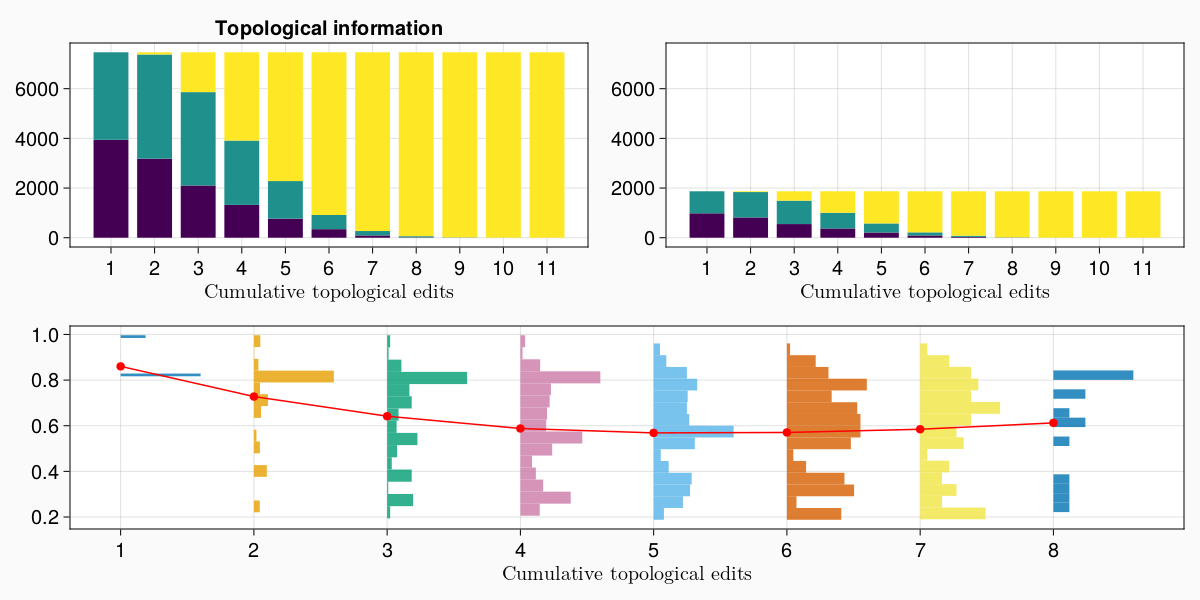

In [95]:
fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (1200, 600),fontsize = 20.)

ax_train = Axis(fig[1,1], xlabel = L"\text{Cumulative topological edits}",title = "Topological information")
ax_test = Axis(fig[1,2],xlabel = L"\text{Cumulative topological edits}")
ax_entropy = Axis(fig[2,1:2],xlabel = L"\text{Cumulative topological edits}")

all_bar_counts = []
all_bar_stack = []
all_bar_x = []

total_tr = 0
total_te = 0

max_ce = maximum(map(tr->tr.top_edits[tr.H0],trajectories_p))

pop = filter(tr->tr.train_test_indicator == :train,trajectories_p)

for r in 1:max_ce
    
    pop_achieved = filter(tr->v_restricted_label_inclusion(tr,x->top_edit_restriction_measure(x,r),:H0),pop)

    pop_not_achieved = filter(tr->!v_restricted_label_inclusion(tr,x->top_edit_restriction_measure(x,r),:H0),pop)

    accuracies  = map(tr->v_restricted_accuracy(tr,x->top_edit_restriction_measure(x,r),:tt),pop_not_achieved)

    mean_ent = map(tr->v_restricted_entropy(tr,x->top_edit_restriction_measure(x,r),:tt),pop_not_achieved)

    bar_counts = [count(x->x==0,accuracies),count(x->x==1,accuracies),length(pop_achieved)]

    bar_stack = [1,2,3]

    bar_x = [r,r,r]

    push!(all_bar_counts,bar_counts)
    push!(all_bar_stack,bar_stack)
    push!(all_bar_x,bar_x)

end

all_bar_counts = reduce(vcat,all_bar_counts)
all_bar_stack = reduce(vcat,all_bar_stack)
all_bar_x = reduce(vcat,all_bar_x);

CairoMakie.barplot!(ax_train,all_bar_x,all_bar_counts,stack = all_bar_stack,color = all_bar_stack)

################################

all_bar_counts = []
all_bar_stack = []
all_bar_x = []

total_tr = 0
total_te = 0

max_ce = maximum(map(tr->tr.top_edits[tr.H0],trajectories_p))

pop = filter(tr->tr.train_test_indicator == :test,trajectories_p)

all_mean_ent = []

for r in 1:max_ce
    
    pop_achieved = filter(tr->v_restricted_label_inclusion(tr,x->top_edit_restriction_measure(x,r),:H0),pop)

    pop_not_achieved = filter(tr->!v_restricted_label_inclusion(tr,x->top_edit_restriction_measure(x,r),:H0),pop)

    accuracies  = map(tr->v_restricted_accuracy(tr,x->top_edit_restriction_measure(x,r),:tt),pop_not_achieved)

    mean_ent = map(tr->v_restricted_entropy(tr,x->top_edit_restriction_measure(x,r),:tt),pop_not_achieved)

    if length(mean_ent) > 2
        hist!(ax_entropy, mean_ent, scale_to= 0.6, offset=r, direction=:x)
        push!(all_mean_ent,mean(mean_ent))
    end

    bar_counts = [count(x->x==0,accuracies),count(x->x==1,accuracies),length(pop_achieved)]

    bar_stack = [1,2,3]

    bar_x = [r,r,r]

    push!(all_bar_counts,bar_counts)
    push!(all_bar_stack,bar_stack)
    push!(all_bar_x,bar_x)

end

CairoMakie.lines!(Float64.(all_mean_ent),color = :red)
CairoMakie.scatter!(Float64.(all_mean_ent),color = :red)

all_bar_counts = reduce(vcat,all_bar_counts)
all_bar_stack = reduce(vcat,all_bar_stack)
all_bar_x = reduce(vcat,all_bar_x);

CairoMakie.barplot!(ax_test,all_bar_x,all_bar_counts,stack = all_bar_stack,color = all_bar_stack)

linkyaxes!(ax_train,ax_test)

ax_train.xticks = (1:max_ce,string.(1:max_ce))
ax_test.xticks = (1:max_ce,string.(1:max_ce))
ax_entropy.xticks = (1:max_ce,string.(1:max_ce))

fig

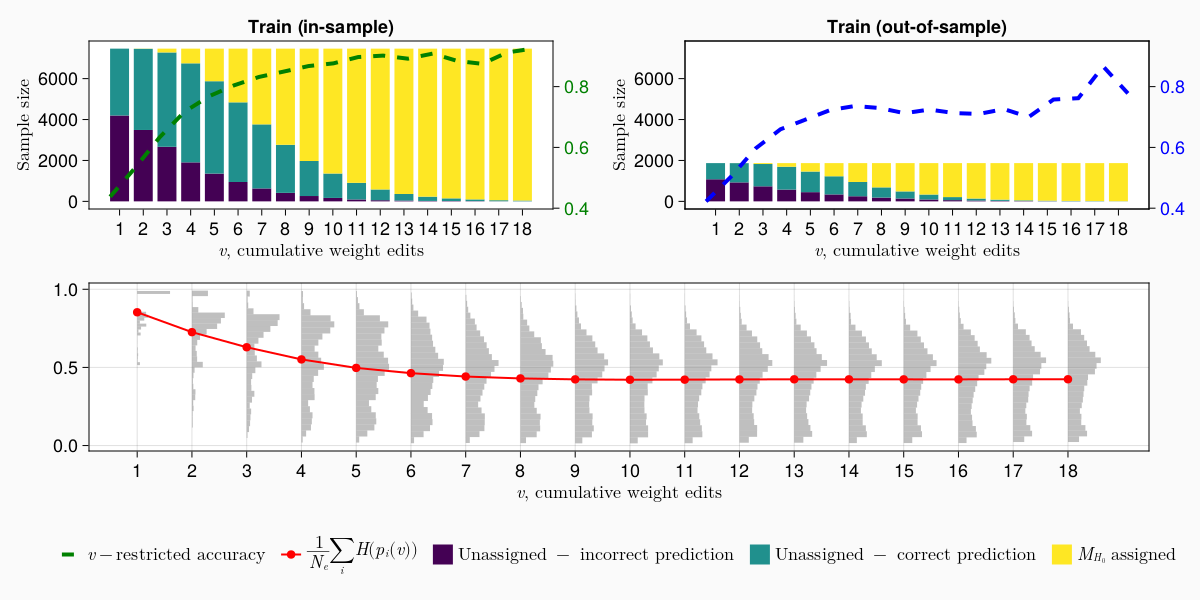

In [147]:
fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (1200, 600),fontsize = 18.)

cp = palette(:viridis, 3)

ax_train = Axis(fig[1,1], xlabel = L"v \text{, cumulative weight edits}", title = "Train (in-sample)", ylabel = L"\text{Sample size}")
ax_test = Axis(fig[1,2],xlabel = L"v \text{, cumulative weight edits}", title = "Train (out-of-sample)",ylabel = L"\text{Sample size}")

ax_train_accuracy = Axis(fig[1,1],yticklabelcolor = :green, yaxisposition = :right)
ax_test_accuracy = Axis(fig[1,2],yticklabelcolor = :blue, yaxisposition = :right,ylabelcolor = :blue)

ax_entropy = Axis(fig[2,1:2],xlabel = L"v \text{, cumulative weight edits}")

all_bar_counts = []
all_bar_stack = []
all_bar_x = []

total_tr = 0
total_te = 0

max_ce = maximum(map(tr->tr.weight_edits[tr.H0],trajectories_p))

max_ce = 18

pop = filter(tr->tr.train_test_indicator == :train,trajectories_p)

mean_accuracies = []

for r in 1:max_ce
    
    pop_achieved = filter(tr->v_restricted_label_inclusion(tr,x->weight_edit_restriction_measure(x,r),:H0),pop)

    pop_not_achieved = filter(tr->!v_restricted_label_inclusion(tr,x->weight_edit_restriction_measure(x,r),:H0),pop)

    accuracies  = map(tr->v_restricted_accuracy(tr,x->weight_edit_restriction_measure(x,r),:gt),pop_not_achieved)

    bar_counts = [count(x->x==0,accuracies),count(x->x==1,accuracies),length(pop_achieved)]

    bar_stack = [1,2,3]

    bar_x = [r,r,r]

    push!(all_bar_counts,bar_counts)
    push!(all_bar_stack,bar_stack)
    push!(all_bar_x,bar_x)

    if length(accuracies) > 1
        push!(mean_accuracies,mean(accuracies))
    end

end

train_ac = CairoMakie.lines!(ax_train_accuracy,Float64.(mean_accuracies),color = :green, linestyle = "--",linewidth = 4.)

all_bar_counts = reduce(vcat,all_bar_counts)
all_bar_stack = reduce(vcat,all_bar_stack)
all_bar_x = reduce(vcat,all_bar_x);

CairoMakie.barplot!(ax_train,all_bar_x,all_bar_counts,stack = all_bar_stack,color = all_bar_stack)

################################

all_bar_counts = []
all_bar_stack = []
all_bar_x = []

total_tr = 0
total_te = 0

pop = filter(tr->tr.train_test_indicator == :test,trajectories_p)

mean_accuracies = []

for r in 1:max_ce
    
    pop_achieved = filter(tr->v_restricted_label_inclusion(tr,x->weight_edit_restriction_measure(x,r),:H0),pop)

    pop_not_achieved = filter(tr->!v_restricted_label_inclusion(tr,x->weight_edit_restriction_measure(x,r),:H0),pop)

    accuracies  = map(tr->v_restricted_accuracy(tr,x->weight_edit_restriction_measure(x,r),:gt),pop_not_achieved)

    # mean_ent = map(tr->v_restricted_entropy(tr,x->weight_edit_restriction_measure(x,r),:gt),pop_not_achieved)

    # if length(mean_ent) > 10
    # hist!(ax_entropy, mean_ent, scale_to= 0.6, offset=r, direction=:x)
    # push!(all_mean_ent,mean(mean_ent))
    # end

    bar_counts = [count(x->x==0,accuracies),count(x->x==1,accuracies),length(pop_achieved)]

    bar_stack = [1,2,3]

    bar_x = [r,r,r]

    push!(all_bar_counts,bar_counts)
    push!(all_bar_stack,bar_stack)
    push!(all_bar_x,bar_x)

    if length(accuracies) > 1
        push!(mean_accuracies,mean(accuracies))
    end

end

test_ac = CairoMakie.lines!(ax_test_accuracy,Float64.(mean_accuracies),color = :blue,linestyle = "--",linewidth = 4.)

all_bar_counts = reduce(vcat,all_bar_counts)
all_bar_stack = reduce(vcat,all_bar_stack)
all_bar_x = reduce(vcat,all_bar_x);

CairoMakie.barplot!(ax_test,all_bar_x,all_bar_counts,stack = all_bar_stack,color = all_bar_stack)

####################

all_mean_ent = []

for r in 1:max_ce
    
    mean_ent = map(tr->v_restricted_entropy(tr,x->weight_edit_restriction_measure(x,r),:gt),trajectories_p)

    hist!(ax_entropy, mean_ent, scale_to= 0.6, offset=r, direction=:x, bins = 25, color = (:grey,0.5))
    push!(all_mean_ent,mean(mean_ent))

end

ent_line = CairoMakie.lines!(ax_entropy,Float64.(all_mean_ent),color = :red, linewidth = 2.)
ent_scatt = CairoMakie.scatter!(ax_entropy,Float64.(all_mean_ent),color = :red)

##################

linkyaxes!(ax_train,ax_test)
linkyaxes!(ax_train_accuracy,ax_test_accuracy)

ax_train.xticks = (1:max_ce,string.(1:max_ce))
ax_test.xticks = (1:max_ce,string.(1:max_ce))
ax_entropy.xticks = (1:max_ce,string.(1:max_ce))

# ax_train.xticklabelrotation = 25.

ax_test.xticks = (1:max_ce,string.(1:max_ce))

# ax_train.xticklabelrotation = 45.
# ax_test.xticklabelrotation = 45.

CairoMakie.hidedecorations!(ax_train,label = false,ticklabels = false,ticks = false,minorticks = false)

CairoMakie.hidedecorations!(ax_test,label = false,ticklabels = false,ticks = false,minorticks = false)

hidespines!(ax_train_accuracy)

hideydecorations!(ax_test_accuracy,label = false,ticklabels = false,ticks = false,minorticks = false)
hidexdecorations!(ax_test_accuracy)

hideydecorations!(ax_train_accuracy,label = false,ticklabels = false,ticks = false,minorticks = false)
hidexdecorations!(ax_train_accuracy)


Legend(fig[3, 1:2],
    vcat([train_ac,[ent_line,ent_scatt]],[PolyElement(color=c) for c in cp]),
    vcat([L"v\text{-restricted accuracy}",L"\frac{1}{N_e}\sum_{i} H(p_{i}(v))"],[L"\text{Unassigned - incorrect prediction}",L"\text{Unassigned - correct prediction}",L"M_{H_0} \text{ assigned}"]),framevisible=false,orientation = :horizontal)

fig

In [141]:
palette(:viridis, 3)

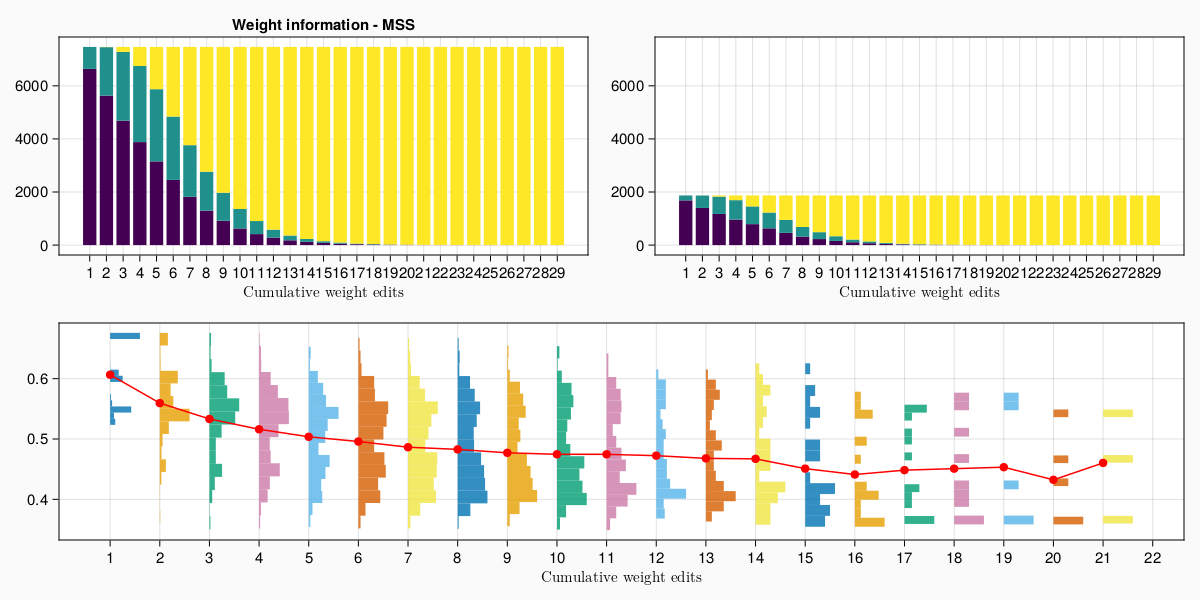

In [114]:
fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (1200, 600),fontsize = 15.)

ax_train = Axis(fig[1,1], xlabel = L"\text{Cumulative weight edits}",title = "Weight information - MSS")
ax_test = Axis(fig[1,2],xlabel = L"\text{Cumulative weight edits}")
ax_entropy = Axis(fig[2,1:2],xlabel = L"\text{Cumulative weight edits}")

all_bar_counts = []
all_bar_stack = []
all_bar_x = []

total_tr = 0
total_te = 0

max_ce = maximum(map(tr->tr.weight_edits[tr.H0],trajectories_p))

pop = filter(tr->tr.train_test_indicator == :train,trajectories_p)

for r in 1:max_ce
    
    pop_achieved = filter(tr->v_restricted_label_inclusion(tr,x->weight_edit_restriction_measure(x,r),:H0),pop)

    pop_not_achieved = filter(tr->!v_restricted_label_inclusion(tr,x->weight_edit_restriction_measure(x,r),:H0),pop)

    accuracies  = map(tr->Int(v_restricted_accuracy(tr,x->weight_edit_restriction_measure(x,r),:mss) == 0),pop_not_achieved)

    mean_ent = map(tr->v_restricted_entropy(tr,x->weight_edit_restriction_measure(x,r),:mss),pop_not_achieved)

    bar_counts = [count(x->x==0,accuracies),count(x->x==1,accuracies),length(pop_achieved)]

    bar_stack = [1,2,3]

    bar_x = [r,r,r]

    push!(all_bar_counts,bar_counts)
    push!(all_bar_stack,bar_stack)
    push!(all_bar_x,bar_x)

end

all_bar_counts = reduce(vcat,all_bar_counts)
all_bar_stack = reduce(vcat,all_bar_stack)
all_bar_x = reduce(vcat,all_bar_x);

CairoMakie.barplot!(ax_train,all_bar_x,all_bar_counts,stack = all_bar_stack,color = all_bar_stack)

################################

all_bar_counts = []
all_bar_stack = []
all_bar_x = []

total_tr = 0
total_te = 0

max_ce = maximum(map(tr->tr.weight_edits[tr.H0],trajectories_p))

pop = filter(tr->tr.train_test_indicator == :test,trajectories_p)

all_mean_ent = []

for r in 1:max_ce
    
    pop_achieved = filter(tr->v_restricted_label_inclusion(tr,x->weight_edit_restriction_measure(x,r),:H0),pop)

    pop_not_achieved = filter(tr->!v_restricted_label_inclusion(tr,x->weight_edit_restriction_measure(x,r),:H0),pop)

    accuracies  = map(tr->Int(v_restricted_accuracy(tr,x->weight_edit_restriction_measure(x,r),:mss) == 0),pop_not_achieved)

    mean_ent = map(tr->v_restricted_entropy(tr,x->weight_edit_restriction_measure(x,r),:mss),pop_not_achieved)

    if length(mean_ent) > 2
        hist!(ax_entropy, mean_ent, scale_to= 0.6, offset=r, direction=:x)
        push!(all_mean_ent,mean(mean_ent))
    end

    bar_counts = [count(x->x==0,accuracies),count(x->x==1,accuracies),length(pop_achieved)]

    bar_stack = [1,2,3]

    bar_x = [r,r,r]

    push!(all_bar_counts,bar_counts)
    push!(all_bar_stack,bar_stack)
    push!(all_bar_x,bar_x)

end

CairoMakie.lines!(Float64.(all_mean_ent),color = :red)
CairoMakie.scatter!(Float64.(all_mean_ent),color = :red)

all_bar_counts = reduce(vcat,all_bar_counts)
all_bar_stack = reduce(vcat,all_bar_stack)
all_bar_x = reduce(vcat,all_bar_x);

CairoMakie.barplot!(ax_test,all_bar_x,all_bar_counts,stack = all_bar_stack,color = all_bar_stack)

linkyaxes!(ax_train,ax_test)

ax_train.xticks = (1:max_ce,string.(1:max_ce))
ax_test.xticks = (1:max_ce,string.(1:max_ce))
ax_entropy.xticks = (1:max_ce,string.(1:max_ce))

fig

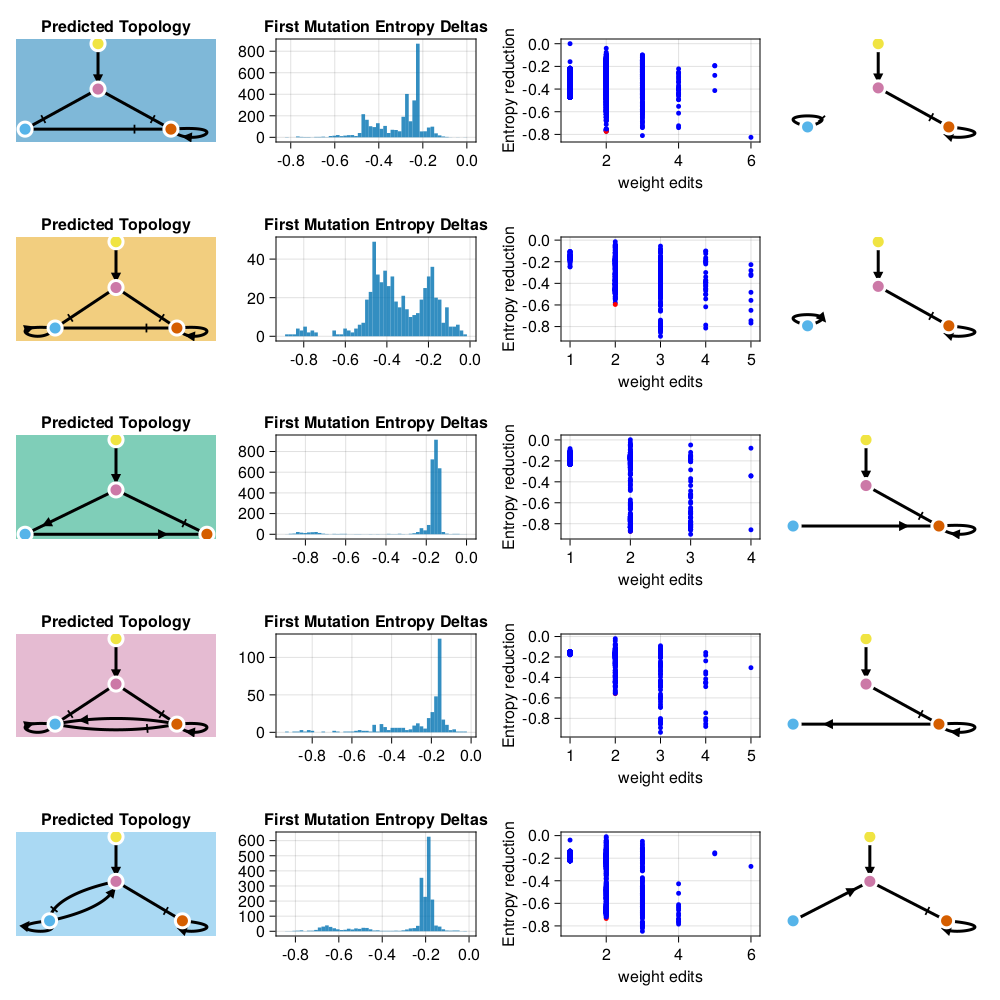

In [148]:
fig = CairoMakie.Figure(resolution = (1000,1000))

mut_n = 1

all_target_mutants = []
all_target_networks = []

for n in 1:top_n

    ax_geno = Axis(fig[n,1],backgroundcolor = (color_scheme[n],0.5), title = "Predicted Topology")

    ax_h = Axis(fig[n,2], title = "First Mutation Entropy Deltas")
    ax_s = Axis(fig[n,3], xlabel = "weight edits", ylabel = "Entropy reduction")

    ax_geno_m = Axis(fig[n,4])

    sample = filter(tr->tr.gt_label_predictions[mut_n+1] ∈ sorted_uep[n],trajectories_p)

    sample_entropy_deltas = map(tr->tr.gt_label_entropies[2:end] .- tr.gt_label_entropies[1:end-1],sample);
    sample_top_edits_deltas = map(tr->tr.weight_edits[2:end] .- tr.weight_edits[1:end-1],sample)

    sample_start_networks = map(tr->tr.geno_traj[mut_n],sample)
    sample_resultant_networks = map(tr->tr.geno_traj[mut_n+1],sample)

    # sample_top_edits_deltas = map(tr->map(mi->length(mi[:weight_id]),tr.mutant_info),sample)

    sample_mutations = map(tr->tr.mutant_info[mut_n],sample)

    sample_top_edits_delta_select = map(x->x[mut_n],sample_top_edits_deltas);

    sample_entropy_delta_select = map(x->x[mut_n],sample_entropy_deltas);

    max_ent_delta = minimum(sample_entropy_delta_select[findall(sample_top_edits_delta_select .== 2)])

    target_mutant_id = findall(sample_top_edits_delta_select .== 2) ∩ findall(sample_entropy_delta_select .== max_ent_delta)

    target_mutant = sample_mutations[target_mutant_id]

    push!(all_target_mutants,target_mutant)

    start_network = sample_start_networks[target_mutant_id[1]]
    resultant_network = sample_resultant_networks[target_mutant_id[1]]

    push!(all_target_networks,(start_network,resultant_network))

    CairoMakie.hist!(ax_h,sample_entropy_delta_select ,bins = 50)

    CairoMakie.scatter!(ax_s,sample_top_edits_delta_select,sample_entropy_delta_select ,markersize = 7., color = [i == target_mutant_id[1] ? :red : :blue for i in 1:length(sample_entropy_delta_select)])

    top = Int.(reshape(vertex_top_map[sorted_uep[n]],(3,4)))

    draw_grn_layout!(ax_geno,top,e_width,vertex_size,arrow_size,arrow_shift,sw,fixed_layout,selfedge_size,node_colors,false)

    top = Int.(sign.(reshape(resultant_network,(3,4))))

    draw_grn_layout!(ax_geno_m,top,e_width,vertex_size,arrow_size,arrow_shift,sw,fixed_layout,selfedge_size,node_colors,false)

end

fig

In [99]:
test_networks = map(x->reshape(x[2],(3,4)), all_target_networks)

5-element Vector{Matrix{Float64}}:
 [0.0 0.0 0.0 1.2490335893436255; 0.0 -0.4653071448603825 0.0 0.0; -0.21577059555519695 0.0 0.8839916974720232 0.0]
 [0.0 0.0 0.0 1.2490335893436255; 0.0 9.783420932139212 0.0 0.0; -0.21577059555519695 0.0 2.9843881434554813 0.0]
 [0.0 0.0 0.0 1.2490335893436255; 0.0 0.0 0.0 0.0; -0.21577059555519695 2.776061959716589 0.16976983631263387 0.0]
 [0.0 0.0 0.0 1.2490335893436255; 0.0 0.0 8.583576419466741 0.0; -0.21577059555519695 0.0 3.651247548915009 0.0]
 [0.0 1.8392494930551262 0.0 1.2490335893436255; 0.0 0.0 0.0 0.0; -0.21577059555519695 0.0 2.202901463495671 0.0]

In [ ]:
# [0.0 0.0 0.0 1.2490335893436255; 0.0 -0.4653071448603825 0.0 0.0; -0.21577059555519695 0.0 0.8839916974720232 0.0]
# [0.0 0.0 0.0 1.2490335893436255; 0.0 9.783420932139212 0.0 0.0; -0.21577059555519695 0.0 2.9843881434554813 0.0]
# [0.0 0.0 0.0 1.2490335893436255; 0.0 0.0 0.0 0.0; -0.21577059555519695 2.776061959716589 0.16976983631263387 0.0]
# [0.0 0.0 0.0 1.2490335893436255; 0.0 0.0 8.583576419466741 0.0; -0.21577059555519695 0.0 3.651247548915009 0.0]
# [0.0 1.8392494930551262 0.0 1.2490335893436255; 0.0 0.0 0.0 0.0; -0.21577059555519695 0.0 2.202901463495671 0.0]

In [ ]:
test_top = map(x->Int.(sign.(reshape(x[2],(3,4)))), all_target_networks)

In [ ]:
# function assign_weight_edits!(tr)

#     we = vcat([0],map(mi->length(mi[:weight_id]),tr.mutant_info))

#     c_we = [sum(we[1:i+1]) for i in 0:length(we)-1]

#     tr.other = c_we
# end

# for tr in trajectories_p
#     assign_weight_edits!(tr)
# end

In [ ]:
for tr in trajectories_p
    assign_weight_edits!(tr)
end

In [ ]:
trajectories_p[1].other

In [ ]:
trajectories_p[1].geno_traj

In [ ]:
CairoMakie.hist(reduce(vcat,sample_entropy_delta_select),bins = 50)

In [ ]:
CairoMakie.scatter(reduce(vcat,sample_top_edits_delta_select),reduce(vcat,sample_entropy_delta_select))

In [ ]:
sample_entropy_deltas[1]

In [ ]:
# max_ce = maximum(map(tr->tr.masked_hamming_distance_H0[1],trajectories_p))

# bin_id = max_ce : -1 : 0 |> collect

# mean_accuracy = [mean(map(tr->v_restricted_accuracy(tr,x->masked_hamming_restriction_measure(x,r,:H0),:gt),trajectories_p)) for r in bin_id]

# mean_ent = [mean(map(tr->v_restricted_entropy(tr,x->masked_hamming_restriction_measure(x,r,:H0),:mss),trajectories_p)) for r in bin_id]
# mean_inc = [mean(map(tr->v_restricted_label_inclusion(tr,x->masked_hamming_restriction_measure(x,r,:H0),:H0),trajectories_p)) for r in bin_id]

#######

# mean_accuracy = [mean(map(tr->v_restricted_accuracy(tr,x->top_edit_restriction_measure(x,r),:mss),trajectories_p)) for r in 0:max_ce]

# # mean_accuracy[1] = 0.

# mean_ent = [mean(map(tr->v_restricted_entropy(tr,x->top_edit_restriction_measure(x,r),:mss),trajectories_p)) for r in 0:max_ce]
# mean_inc = [mean(map(tr->v_restricted_label_inclusion(tr,x->top_edit_restriction_measure(x,r),:H0),trajectories_p)) for r in 0:max_ce]

max_ce = maximum(map(tr->tr.masked_hamming_distanceb_H0[2][tr.H0],trajectories_p))

bin_id = 0:max_ce |> collect

mean_accuracy = [mean(map(tr->v_restricted_accuracy(tr,x->masked_hamming_restriction_measure_begin(x,r),:gt),trajectories_p)) for r in 0:max_ce]

mean_accuracy[1] = 0.

mean_ent = [mean(map(tr->v_restricted_entropy(tr,x->masked_hamming_restriction_measure_begin(x,r),:gt),trajectories_p)) for r in 0:max_ce]
mean_inc = [mean(map(tr->v_restricted_label_inclusion(tr,x->masked_hamming_restriction_measure_begin(x,r),:H0),trajectories_p)) for r in 0:max_ce]


In [ ]:
f = Figure(resolution = (800,800), fontsize = 20.)
ax1 = Axis(f[1, 1], xlabel = L"\text{Cumulative topological edits, e}", ylabel = L"\text{Average Entropy, } \mathbb{E}[H(p^{i}_n)]",yticklabelcolor = :red,ylabelcolor = :red,ytickcolor = :red)
ax2 = Axis(f[1, 1], ylabel = L"\text{Percentage of genotypes (%)}",yaxisposition = :right)

# bin_id = filter_bin_values_by_min_count(all_entropy_ce,100);

st_s = CairoMakie.scatter!(ax2,bin_id,mean_inc, color = :green, marker = '◼')
st_l = CairoMakie.lines!(ax2,bin_id,mean_inc, color = :green)

ent_s_cts = CairoMakie.scatter!(ax1,bin_id,mean_ent, color = :pink)
ent_l_cts = CairoMakie.lines!(ax1,bin_id,mean_ent, color = :pink)

acc_s_cts = CairoMakie.scatter!(ax2,bin_id,mean_accuracy, color = :purple, marker = :x)
acc_l_cts = CairoMakie.lines!(ax2,bin_id,mean_accuracy, color = :purple)

ax1.xticks = (0:maximum(bin_id))

hidexdecorations!(ax2)
hideydecorations!(ax2,label = false,ticklabels = false,ticks = false)

hidespines!(ax2)
linkxaxes!(ax1, ax2)
linkyaxes!(ax1, ax2)


# Legend(f[2, 1],
#     [[ent_s, ent_l], [acc_s, acc_l], [st_s, st_l]],
#     [L"\mathbb{E}[H(p^{i}_n) | n = e]", L"\mathbb{1}(\text{argmin}p^{i}_{n} = T^{i}_{\infty})",  L"\mathbb{1}(T^{i}_{\infty} \subseteq T^{i}_{n})"],orientation = :horizontal)

Legend(f[2, 1],
    [[ent_s_cts, ent_l_cts], [acc_s_cts, acc_l_cts], [st_s, st_l]],
    ["Average \n MM prediction entropy", "Average \n MM prediction accuracy", "Proportion of Trajectories \n with MM inclusion"],orientation = :horizontal)
f

In [ ]:
# instead of "has achieved stripe" coud do "has incorporated minimal topology"
# need to really include AUC or some other measure, i.e. whats the null comparison given very unbalanced classes, if I just vote majority class - whats the discrimination 

In [ ]:
# model.save_model("PredEndMinimal.json")

# model_cts.save_model("PredEndMinimalCts.json")

In [ ]:
function evaluate_epistasis_class(mut_tuple,grn_parameters,development,fitness_function)

    n_mut = length(mut_tuple[:mut_id])

    if n_mut > 1

        mut_combi = [[bit == '1' ? true : false for bit in string(i;base = 2,pad = n_mut)] for i in 1:2^n_mut-1]

        accept_new_mutant = []

        for mut_id in mut_combi[1:end-1]

            new_network = noise_specified(mut_tuple[:existing_network],mut_tuple[:mut_id][mut_id],mut_tuple[:mut_size][mut_id],mut_tuple[:mut_type][mut_id])

            mutant = Individual(reshape(new_network,(3,4)),grn_parameters,development)

            mutant_fitness = fitness_function(mutant.phenotype)

            fix_p = fixation_probability(mutant_fitness[1] - mut_tuple[:existing_fitness][1],mutant_fitness[2] - mut_tuple[:existing_fitness][2],β)

            push!(accept_new_mutant,fix_p > 0)

        end

        rtype = :ne

        if !any(accept_new_mutant)
            rtype = :rse

        else
            for mut_id in 1:n_mut
                accept_id = findall(x->x[mut_id],mut_combi[1:end-1])
                if any([!x for x in accept_new_mutant[accept_id]])
                    rtype = :se
                end
            end
        end
    else
        rtype = :sm
    end

    return rtype
end

function calculate_epi_class_proportion(epi_class)
    
    total = length(epi_class)

    return [count(x->x==ec,epi_class)/total for ec in [:rse,:se,:ne,:sm]]
end

function calculate_epi_class_proportion(epi_class,epi_class_totals)
    
    return [count(x->x==ec,epi_class) for ec in [:rse,:se,:ne,:sm]] ./ epi_class_totals
end

In [ ]:
# epi_ent = map(x->entropy(max.(x,0) ./ sum(max.(x,0))),all_shap_epi);

# cedit_epi_ent = [(mi[:c_edit],ee) for (mi,ee) in zip(all_mut_info,epi_ent)];

# epi_ent_vectors = [map(d->d[2],filter(x->x[1] == i, cedit_epi_ent)) for i in bin_id];

# mean_epi_ent = [mean(v) for v in epi_ent_vectors];

In [ ]:
# all_class_epi = map(mt->map(mi->evaluate_epistasis_class(mi,grn_parameters,DefaultGRNSolver(),fitness_function),mt),mutation_data);

# cedit_epi_class = [(mi[:c_edit],ee) for (mi,ee) in zip(all_mutation_data,all_class_epi)];

# epi_class_d = reduce(hcat,[calculate_epi_class_proportion(map(x->x[2],filter(x->x[1] == bin,cedit_epi_class))) for bin in bin_id]);

all_class_epi = map(mi->evaluate_epistasis_class(mi,grn_parameters,DefaultGRNSolver(),fitness_function),all_mutation_data);

cedit_epi_class = [(mi[:c_edit],ee) for (mi,ee) in zip(all_mutation_data,all_class_epi)];

epi_class_d = reduce(hcat,[calculate_epi_class_proportion(map(x->x[2],filter(x->x[1] == bin,cedit_epi_class))) for bin in bin_id]);

In [ ]:
# save("all_class_epi.jld2",all_class_epi)

In [ ]:
# epi_class_totals = [count(x->x[2]==ec,cedit_epi_class) for ec in [:rse,:se,:ne,:sm]]

# epi_class_d = reduce(hcat,[calculate_epi_class_proportion(map(x->x[2],filter(x->x[1] == bin,cedit_epi_class))) for bin in bin_id]);

In [ ]:
function get_first_positive(v)

    v_id = filter(x->x[2] == 1,v)

    if length(v_id) > 1

        v_id_sort = sort(v_id,by = x->x[1])

        return v_id_sort[1][1]

    elseif length(v_id) == 1
        return v_id[1][1]
    else
        return NaN
    end

end


In [ ]:
first_stripe_occ = map(x->get_first_positive(x),stripe_ce_incl_end)
first_inclusion_occ= map(x->get_first_positive(x),inclusion_ce_incl_end);

In [ ]:
stripe_incl_heatmap = zeros(maximum(bin_id)+1,maximum(bin_id)+1)

for i in 0:maximum(bin_id)
    for j in 0:maximum(bin_id)
        x = sum((first_stripe_occ .== i) .& (first_inclusion_occ.== j))

        stripe_incl_heatmap[i+1,j+1] = x .!= 0 ? x : NaN
    end
end

In [ ]:
using LinearAlgebra

In [ ]:
# dav = dmat_cell[fs_keep,fs_keep]

# cu_thresh =  0

# # hc1 = hclust(dav,linkage = :single,branchorder = :optimal)

# hc1 = hclust(dav,linkage = :single)

# # clust_labels = cutree(hc1,h = cu_thresh)

# p1 = hline!(StatsPlots.plot(hc1,xticks = false,label = nothing,ylabel = "Dynamical similarity"),[cu_thresh],linestyle = :dash)
# p2 = StatsPlots.heatmap(reshape(fs_min[hc1.order],(1,length(fs_min))),colorbar=false,yticks = false,xticks = false, colormap = [:green,:orange,:blue])

# # h2 = StatsPlots.scatter([0,0], [0,1], zcolor=[1,5],
# #              xlims=(1,1.1), label="",c=palette([:red,:green,:yellow,:blue,:pink]),colorbar_title="Topology", framestyle=:none)

# l = @layout [StatsPlots.grid(2, 1,heights=[0.8,0.1])]

# p_all = StatsPlots.plot(p1, p2, layout=l)

# # StatsPlots.savefig(p_all,plotsdirx("Experiment_1/Report","DynamicalSimilarityDendrogram.pdf"))

# p_all

In [ ]:
# dav = dmat_av[fs_keep,fs_keep]

# cu_thresh =  0

# # hc1 = hclust(dmat_av[fs_keep,fs_keep],linkage = :single,branchorder = :optimal)

# hc1 = hclust(dmat_av[fs_keep,fs_keep],linkage = :single)

# # clust_labels = cutree(hc1,h = cu_thresh)

# p1 = hline!(StatsPlots.plot(hc1,xticks = false,label = nothing,ylabel = "Dynamical similarity"),[cu_thresh],linestyle = :dash)
# p2 = StatsPlots.heatmap(reshape(fs_min[hc1.order],(1,length(fs_min))),colorbar=false,yticks = false,xticks = false, colormap = [:green,:orange,:blue])

# # h2 = StatsPlots.scatter([0,0], [0,1], zcolor=[1,5],
# #              xlims=(1,1.1), label="",c=palette([:red,:green,:yellow,:blue,:pink]),colorbar_title="Topology", framestyle=:none)

# l = @layout [StatsPlots.grid(2, 1,heights=[0.8,0.1])]

# p_all = StatsPlots.plot(p1, p2, layout=l)

# StatsPlots.savefig(p_all,plotsdirx("Experiment_1/Update","DynamicalSimilarityDendrogram.pdf"))

# p_all

In [ ]:
fig = CairoMakie.Figure(resolution = (800,500))
# ax = Axis(fig[1,1], xlabel = L"\text{Cumulative topological edits until } \mathbb{1}(\text{T^{i}_{n} forms stripe})",ylabel = L"\text{Cumulative topological edits until } \mathbb{1}(T^{i}_{\infty} \subseteq T^{i}_{n})")

ax = Axis(fig[1,1], xlabel = "Cumulative topological edits until trajectory achieves stripe",ylabel = "Cumulative topological edits \n until trajectory \n incorporates MM",ylabelrotation = 2pi)

CairoMakie.heatmap!(ax,stripe_incl_heatmap)

agreement = sum(filter(x->!isnan(x),diag(stripe_incl_heatmap))) ./ length(first_stripe_occ)

CairoMakie.text!(ax,[Point2f(2,12)],text = ["Agreement = " * string(round(agreement*100,digits =2)) * "%"])

ax.xticks = (1:maximum(bin_id)+1,string.(0:maximum(bin_id)))

ax.yticks = (1:maximum(bin_id)+1,string.(0:maximum(bin_id)))

# save(plotsdirx("Experiment_1/Update","StripeInclusionAgreement.pdf"),fig,pt_per_unit = 1)

fig

In [ ]:
sum(fs_minimal[fs_keep] .== end_minimal[fs_keep])

In [ ]:
f = Figure(resolution = (1600,800), fontsize = 20.)
# ax1 = Axis(f[1, 1], xlabel = L"\text{Cumulative topological edits, e}", ylabel = L"\text{Average Entropy, } \mathbb{E}[H(p^{i}_n)]",yticklabelcolor = :red,ylabelcolor = :red,ytickcolor = :red,ylabelrotation = 2pi)
# ax2 = Axis(f[1, 1], ylabel = L"\text{Percentage of genotypes (%)}",yaxisposition = :right,ylabelrotation = 2pi)

ax1 = Axis(f[1, 1], xlabel = "Cumulative topological edits",yticklabelcolor = :red,ylabelcolor = :red,ytickcolor = :red,ylabelrotation = 2pi)
ax2 = Axis(f[1, 1] ,yaxisposition = :right,ylabelrotation = 2pi)

bin_id = 0:max_ce |> collect

mean_ent = [mean(map(v->get_latest_prediction(v,i),entropy_ce)) for i in bin_id]

mean_accuracy = [mean(map(v->get_latest_prediction(v,i),accuracy_ce)) for i in bin_id]

mean_inc = [mean(map(v->get_latest_prediction(v,i),inclusion_ce)) for i in bin_id]


ent_s = CairoMakie.scatter!(ax1,bin_id,mean_ent, color = :red)
ent_l = CairoMakie.lines!(ax1,bin_id,mean_ent, color = :red)

acc_s = CairoMakie.scatter!(ax2,bin_id,mean_accuracy, color = :blue, marker = :x)
acc_l = CairoMakie.lines!(ax2,bin_id,mean_accuracy, color = :blue)

st_s = CairoMakie.scatter!(ax2,bin_id,mean_inc, color = :green, marker = '◼')
st_l = CairoMakie.lines!(ax2,bin_id,mean_inc, color = :green)

ax1.xticks = (0:max_ce)

hidexdecorations!(ax2)
hideydecorations!(ax2,label = false,ticklabels = false,ticks = false)

hidespines!(ax2)
linkxaxes!(ax1, ax2)
linkyaxes!(ax1, ax2)

# Legend(f[2, 1],
#     [[ent_s, ent_l], [acc_s, acc_l], [st_s, st_l]],
#     [L"\mathbb{E}[H(p^{i}_n) | n = e]", L"\mathbb{1}(\text{argmin}p^{i}_{n} = T^{i}_{\infty})", L"\mathbb{1}(T^{i}_{\infty} \subseteq T^{i}_{n})"],orientation = :horizontal)

Legend(f[2, 1],
    [[ent_s, ent_l], [acc_s, acc_l], [st_s, st_l]],
    ["Average \n Trajectory Entropy", "Average \n Trajectory Accuracy", "Proportion of Trajectories \n including MM"],orientation = :horizontal)


#############################

# ax3 = Axis(f[1, 2], xlabel = L"\text{Cumulative topological edits, e}", ylabel = L"\text{Percentage of mutants generated (%)}")
# ax4 = Axis(f[1, 2], ylabel = L"\text{Percentage of genotypes (%)}",yaxisposition = :right,yticklabelcolor = :green,ylabelcolor = :green,ytickcolor = :green)

ax3 = Axis(f[1, 2], xlabel = "Cumulative topological edits")
ax4 = Axis(f[1, 2] ,yaxisposition = :right,yticklabelcolor = :green,ylabelcolor = :green,ytickcolor = :green)

rse_s = CairoMakie.scatter!(ax3,bin_id,epi_class_d[1,:], color = :purple)
rse_l = CairoMakie.lines!(ax3,bin_id,epi_class_d[1,:], color = :purple)

se_s = CairoMakie.scatter!(ax3,bin_id,epi_class_d[2,:], color = :cyan, marker = :x)
se_l = CairoMakie.lines!(ax3,bin_id,epi_class_d[2,:], color = :cyan)

ne_s = CairoMakie.scatter!(ax3,bin_id,epi_class_d[3,:], color = :black, marker = '◼')
ne_l = CairoMakie.lines!(ax3,bin_id,epi_class_d[3,:], color = :black)

sm_s = CairoMakie.scatter!(ax3,bin_id,epi_class_d[4,:], color = :pink, marker = '▲')
sm_l = CairoMakie.lines!(ax3,bin_id,epi_class_d[4,:], color = :pink)

st_s = CairoMakie.scatter!(ax4,bin_id,mean_inc, color = :green, marker = '◼')
st_l = CairoMakie.lines!(ax4,bin_id,mean_inc, color = :green)

ax3.xticks = (0:maximum(bin_id))

hidexdecorations!(ax4)
hideydecorations!(ax4,label = false,ticklabels = false,ticks = false)

hidespines!(ax4)
linkxaxes!(ax3, ax4)
linkyaxes!(ax3, ax4)


# Legend(f[2, 2],
#     [[rse_s, rse_l], [se_s, se_l], [ne_s, ne_l],[sm_s, sm_l],[st_s, st_l]],
#     [L"\text{RSE}", L"\text{SE}", L"\text{No Epistasis}",L"\text{Single Mutations}",L"\mathbb{1}(T^{i}_{\infty} \subseteq T^{i}_{n} \text{ and } E(T^{i}_{n}) \leq e)"],orientation = :horizontal)


Legend(f[2, 2],
    [[rse_s, rse_l], [se_s, se_l], [ne_s, ne_l],[sm_s, sm_l],[st_s, st_l]],
    ["RSE", "SE", "No Epistasis","Single \n Mutations","Proportion of Trajectories \n including MM"],orientation = :horizontal)

# save(plotsdirx("Experiment_1/Update","PredictionAndEpistasisSummary.pdf"),f,pt_per_unit = 1)

f

In [ ]:
corspearman(epi_class_d[2,:],mean_ent)

# i.e. we are adding noise, weight changes which dont correspoond to functional changes. This should increase model uncertainty. Can we design some "efficiency" metric, in termms of ratio of functional weights to non_functional or similar?

In [ ]:
# Given shapley attributions in final network, can we predict these using cts values of weights in a similar manner. Regression vs classification => do entire dataset. Plus, 

In [ ]:
tte_incl_any_all = reduce(vcat,tte_incl_any);

In [ ]:
# tte_cedit_2 = unique(map(x->collect(x[2]),tte_cedit_all));

valid_pre_stripe = findall(x->x[1] ∈ [2],tte_cedit_all) ∩ findall(x->x[1] != 1,tte_incl_any_all)

tte_cedit_2 = unique(map(x->collect(x[2]),tte_cedit_all[valid_pre_stripe]));

In [ ]:
length(tte_cedit_2)

In [ ]:
map(x->x[:existing_network],filter(x->sign.(x[:existing_network]) ∈ tte_cedit_2,all_mutation_data))

In [ ]:
min_n_mut = 100

tte_cedit_2_epi = []

tte_cedit_2_repr = []

for tt in tte_cedit_2
    representation = sum(mapslices(x->x == tt[1:10], X_train, dims = 2))

    push!(tte_cedit_2_repr,representation)

    push!(tt_cedit_2_top_networks,map(x->x[:existing_network],filter(x->sign.(x[:existing_network]) ∈ tte_cedit_2,all_mutation_data)))

    epi_types = all_class_epi[findall(x->sign.(x[:existing_network]) == tt,all_mutation_data)]
    push!(tte_cedit_2_epi,(calculate_epi_class_proportion(epi_types),length(epi_types)))
end

high_freq_cedit_2 = findall(x->x[2] > min_n_mut,tte_cedit_2_epi);

rse_cedit_2 = map(x->x[1][1],tte_cedit_2_epi[high_freq_cedit_2]);

se_cedit_2 = map(x->x[1][2],tte_cedit_2_epi[high_freq_cedit_2]);

ne_cedit_2 = map(x->x[1][3],tte_cedit_2_epi[high_freq_cedit_2]);

sm_cedit_2 = map(x->x[1][4],tte_cedit_2_epi[high_freq_cedit_2]);

repr_cedit_2 = tte_cedit_2_repr[high_freq_cedit_2]

tte_cedit_2_data = reduce(hcat,tte_cedit_2)[1:10,high_freq_cedit_2];

tte_dtrain_cedit_2 = xgboost.DMatrix(tte_cedit_2_data |> transpose |> collect, feature_types = c_types, feature_names = weight_names)

tte_pred_cedit_2 = model.predict(tte_dtrain_cedit_2);

entropy_cedit_2 = mapslices(p->entropy(p),tte_pred_cedit_2, dims = 2)[:,1];

In [ ]:
fig = CairoMakie.Figure(resolution = (600,500))

ax1 = Axis(fig[1,1],ylabel = "Trajectory \n count",ylabelrotation = 2pi, xlabel = "Entropy of prediction probability", title = "Distribution of prediction entropies at e = 2")

CairoMakie.hist!(ax1,map(v->get_latest_prediction(v,2),entropy_ce), bins =length(tte_cedit_2))

# save(plotsdirx("Experiment_1/Update","HistogramOfE=2PredictionEntropies.pdf"),fig,pt_per_unit = 1)

fig

In [ ]:
repr_cedit_2_sizes = repr_cedit_2 ./ sum(repr_cedit_2);

In [ ]:
fig = CairoMakie.Figure(resolution = (1400,1000))
ax1 = Axis(fig[1,1],ylabel = "Proportion of \n accepted mutants \n demonstrating RSE",ylabelrotation = 2pi, xlabel = "Entropy of topology prediction probability")
ax2 = Axis(fig[1,2],ylabel = "Proportion of \n accepted mutants \n demonstrating SE",ylabelrotation = 2pi, xlabel = "Entropy of topology prediction probability")

ax3 = Axis(fig[2,1],ylabel = "Proportion of \n accepted mutants \n demonstrating NE",ylabelrotation = 2pi, xlabel = "Entropy of topology prediction probability")
ax4 = Axis(fig[2,2],ylabel = "Proportion of \n accepted mutants \n demonstrating SM",ylabelrotation = 2pi, xlabel = "Entropy of topology prediction probability")

CairoMakie.scatter!(ax1,entropy_cedit_2,rse_cedit_2, markersize = 500 .* repr_cedit_2_sizes)

CairoMakie.scatter!(ax2,entropy_cedit_2,se_cedit_2, markersize = 500 .* repr_cedit_2_sizes,color = :orange)

CairoMakie.scatter!(ax3,entropy_cedit_2,ne_cedit_2, markersize = 500 .* repr_cedit_2_sizes)

CairoMakie.scatter!(ax4,entropy_cedit_2,sm_cedit_2, markersize = 500 .* repr_cedit_2_sizes,color = :orange)

# CairoMakie.scatter!(ax1,entropy_cedit_2,rse_cedit_2)

# CairoMakie.scatter!(ax2,entropy_cedit_2,se_cedit_2,color = :orange)

# CairoMakie.scatter!(ax3,entropy_cedit_2,ne_cedit_2)

# CairoMakie.scatter!(ax4,entropy_cedit_2,sm_cedit_2,color = :orange)

CairoMakie.text!(ax1,[Point2f(0.65,0.3)],text = ["Spearman = " * string(round(corspearman(entropy_cedit_2,rse_cedit_2)*100,digits =2)) * "%"])

CairoMakie.text!(ax2,[Point2f(0.2,0.3)],text = ["Spearman = " * string(round(corspearman(entropy_cedit_2,se_cedit_2)*100,digits =2)) * "%"])

CairoMakie.text!(ax3,[Point2f(0.25,0.1)],text = ["Spearman = " * string(round(corspearman(entropy_cedit_2,ne_cedit_2)*100,digits =2)) * "%"])

CairoMakie.text!(ax4,[Point2f(0.25,0.4)],text = ["Spearman = " * string(round(corspearman(entropy_cedit_2,sm_cedit_2)*100,digits =2)) * "%"])

# linkyaxes!([ax1, ax2,ax3,ax4]...)

# save(plotsdirx("Experiment_1/Update","EntropyAndEpistasis.pdf"),fig,pt_per_unit = 1)

fig

In [ ]:
tte_traj = [unique(hcat([utte_dict[collect(t)] for t in eachcol(tt)],id),dims = 1) for (tt,id) in zip(tte,inclusion_any_data)];

# tte_traj = [[utte_dict[collect(t)] for t in eachcol(tt)] for tt in tte];

tte_traj[1]

In [ ]:
tte_traj_steps = [collect(zip(traj[1:end-1,1],traj[2:end,1])) for traj in tte_traj]

tte_entropy_delta = [ent[2:end] .- ent[1:end-1] for ent in map(x->unique(x),tte_entropy)]

tte_p = [[collect(pred) for pred in eachrow(unique(tte_p,dims =1))] for tte_p in tte_pred]

step_ent_delta = [collect(zip(step,edelta)) for (step,edelta) in zip(tte_traj_steps,tte_entropy_delta)]

cedit_step_ent_delta = [collect(zip(unique(c_edit)[2:end],data)) for (c_edit,data) in zip(c_edits,step_ent_delta)]; # c_edit RESULTING from transition. Interested in c_edit 1->2, 1-> 3

transition_ent_delta = [[(d[1],d[2][1],d[2][2],incl) for (d,incl) in zip(data,tt[2:end,2])] for (data,tt) in zip(cedit_step_ent_delta,tte_traj)];

transition_ent_delta_pold = [[(d[1],d[2],d[3],d[4],prob) for (d,prob) in zip(data,pred[2:end])] for (data,pred) in zip(transition_ent_delta,tte_p)];

transition_ent_delta_p = [[(d[1],d[2],d[3],d[4],d[5],prob) for (d,prob) in zip(data,pred[1:end-1])] for (data,pred) in zip(transition_ent_delta_pold,tte_p)];

In [ ]:
transition_ent_delta_p[1]

In [ ]:
all_transition_ent_delta = reduce(vcat,transition_ent_delta_p);

In [ ]:
ent_delta_ordered = sort(unique(filter(x->(x[1]==2) & (x[4] != 1),all_transition_ent_delta)), by = x->x[3])

In [ ]:
keep_rename_rev = Dict(v=>k for (k,v) in keep_rename);

In [ ]:
ent_delt_id = 30

In [ ]:
fig = CairoMakie.Figure(resolution = (800,800))

arrow_size = 30.
arrow_shift = 0.3
e_width = 6.

axs = Axis(fig[1,1:3])
axe = Axis(fig[2,1:3])

ax1 = Axis(fig[3,1])
ax2 = Axis(fig[3,2])
ax3 = Axis(fig[3,3])

st_trans = ent_delta_ordered[ent_delt_id][2][1]
end_trans = ent_delta_ordered[ent_delt_id][2][2]

st_network = reshape(sorted_utte[:,st_trans],(3,4))
end_network = reshape(sorted_utte[:,end_trans],(3,4))

old_prob = ent_delta_ordered[ent_delt_id][6]
new_prob = ent_delta_ordered[ent_delt_id][5]

final_top_pred = [reshape(minimal_top[:,keep_rename_rev[i]],(3,4)) for i in 1:3]

draw_grn_cn_th!(axs,st_network,e_width ,arrow_size,arrow_shift)

draw_grn_cn_th!(axe,end_network,e_width ,arrow_size,arrow_shift)

draw_grn_cn_th!(ax1,final_top_pred[1],e_width ,arrow_size,arrow_shift)
draw_grn_cn_th!(ax2,final_top_pred[2],e_width ,arrow_size,arrow_shift)
draw_grn_cn_th!(ax3,final_top_pred[3],e_width ,arrow_size,arrow_shift)

CairoMakie.text!(ax1,[Point2f(0.75,1.5)],text = ["p = " * string(round(old_prob[1],digits = 3))], color = "red")
CairoMakie.text!(ax1,[Point2f(0.75,1.)],text = ["p = " * string(round(new_prob[1],digits = 3))], color = "green")

CairoMakie.text!(ax2,[Point2f(0.75,1.5)],text = ["p = " * string(round(old_prob[2],digits = 3))], color = "red")
CairoMakie.text!(ax2,[Point2f(0.75,1.)],text = ["p = " * string(round(new_prob[2],digits = 3))], color = "green")

CairoMakie.text!(ax3,[Point2f(0.75,1.5)],text = ["p = " * string(round(old_prob[3],digits = 3))], color = "red")
CairoMakie.text!(ax3,[Point2f(0.75,1.)],text = ["p = " * string(round(new_prob[3],digits = 3))], color = "green")

save(plotsdirx("Experiment_1/Update","ExampleE=2TransitionId=30.pdf"),fig,pt_per_unit = 1)

fig

In [ ]:
# should add baseline for slcoses
# look at how often it is this minimal version (1) above versus with the excitory on B

In [ ]:
complexity_utte = sum(abs.(unique_top_to_end),dims = 1)[1,:]

sorted_utte = unique_top_to_end[:,sortperm(complexity_utte)];

In [ ]:
number_utte = size(sorted_utte,2)
 
sorted_utte_incl = zeros(Int,(number_utte,number_utte))

for i in 1:number_utte
    for j in 1:number_utte
        if i != j
            sorted_utte_incl[i,j] = test_inclusion(sorted_utte[:,j],sorted_utte[:,i])
        end
    end
end

In [ ]:
sorted_utte_incl

In [ ]:
function mask_by_id(network,keep_id)

    new_network = copy(network)

    z0 = findall(x->!(x ∈ keep_id),1:length(network))

    new_network[z0] .= 0.

    return new_network

end

function mask(network,mask)

    new_network = copy(network)

    z0 = findall(x->!x,mask)

    new_network[z0] .= 0.

    return new_network

end

function evaluate_epistasis_shapley(mut_tuple,grn_parameters,development,fitness_function)

    size_S = length(mut_tuple[:mut_id])

    powerset_S = [[bit == '1' ? true : false for bit in string(i;base = 2,pad = size_S)] for i in 0:2^size_S-1]

    shapley_values = zeros(size_S)

    og_fitness = add_fitness(mut_tuple[:existing_fitness])

    og_fitness_delta = add_fitness(mut_tuple[:mutant_fitness]) - og_fitness 

    if size_S != 1

        for i in 1:size_S
            powerset_S_minus_i = filter(x->!x[i],powerset_S)

            ϕi = 0

            for Q in powerset_S_minus_i 

                size_Q = sum(Q)

                normalize_coefficient = (factorial(size_Q)*factorial(size_S - size_Q - 1))/factorial(size_S)

                Q_add_i = copy(Q)

                Q_add_i[i] = true

                new_network_i = noise_specified(mut_tuple[:existing_network],mut_tuple[:mut_id][Q_add_i],mut_tuple[:mut_size][Q_add_i],mut_tuple[:mut_type][Q_add_i])

                mutant_i = Individual(reshape(new_network_i,(3,4)),grn_parameters,development)

                mutant_fitness_i = fitness_function(mutant_i.phenotype)

                # f_Q_add_i = max(0,fixation_probability(mutant_fitness_i[1] - mut_tuple[:existing_fitness][1],mutant_fitness_i[2] - mut_tuple[:existing_fitness][2],β))

                f_Q_add_i = add_fitness(mutant_fitness_i) - og_fitness 

                new_network = noise_specified(mut_tuple[:existing_network],mut_tuple[:mut_id][Q],mut_tuple[:mut_size][Q],mut_tuple[:mut_type][Q])

                mutant = Individual(reshape(new_network,(3,4)),grn_parameters,development)

                mutant_fitness = fitness_function(mutant.phenotype)

                # f_Q = max(0,fixation_probability(mutant_fitness[1] - mut_tuple[:existing_fitness][1],mutant_fitness[2] - mut_tuple[:existing_fitness][2],β))

                f_Q = add_fitness(mutant_fitness) - og_fitness 
                
                ϕi += normalize_coefficient*(f_Q_add_i - f_Q)
            end

            shapley_values[i] = ϕi

        end
    else
        shapley_values[1] = og_fitness_delta
    end

    return shapley_values
end


function evaluate_smj_shapley(smj,start_network,grn_parameters,development,fitness_function)

    non_zero_smj = findall(x->x!=0,smj)

    size_S = length(non_zero_smj)

    powerset_S = [[bit == '1' ? true : false for bit in string(i;base = 2,pad = size_S)] for i in 0:2^size_S-1]

    shapley_values = zeros(length(start_network))

    for (i,w_id) in enumerate(non_zero_smj)

        powerset_S_minus_i = filter(x->!x[i],powerset_S)

        ϕi = 0

        for Q in powerset_S_minus_i 

            size_Q = sum(Q)

            normalize_coefficient = (factorial(size_Q)*factorial(size_S - size_Q - 1))/factorial(size_S)

            Q_add_i = copy(Q)

            Q_add_i[i] = true

            new_network_i = start_network .+ mask_by_id(smj,non_zero_smj[Q_add_i])

            mutant_i = Individual(reshape(new_network_i,(3,4)),grn_parameters,development)

            mutant_fitness_i = fitness_function(mutant_i.phenotype)

            f_Q_add_i = add_fitness(mutant_fitness_i)

            new_network = start_network .+ mask_by_id(smj,non_zero_smj[Q])

            mutant = Individual(reshape(new_network,(3,4)),grn_parameters,development)

            mutant_fitness = fitness_function(mutant.phenotype)

            f_Q = add_fitness(mutant_fitness)
            
            ϕi += normalize_coefficient*(f_Q_add_i - f_Q)
        end

        shapley_values[w_id] = ϕi

    end

    return shapley_values
end

function evaluate_network_shapley(network,grn_parameters,development,fitness_function)

    size_S = length(network)

    powerset_S = [[bit == '1' ? true : false for bit in string(i;base = 2,pad = size_S)] for i in 0:2^size_S-1]

    shapley_values = zeros(size_S)

    for i in 1:size_S
        powerset_S_minus_i = filter(x->!x[i],powerset_S)

        ϕi = 0

        for Q in powerset_S_minus_i 

            size_Q = sum(Q)

            normalize_coefficient = (factorial(size_Q)*factorial(size_S - size_Q - 1))/factorial(size_S)

            Q_add_i = copy(Q)

            Q_add_i[i] = true

            new_network_i = vcat(mask(network,Q_add_i),[0.,0.])

            mutant_i = Individual(reshape(new_network_i,(3,4)),grn_parameters,development)

            mutant_fitness_i = fitness_function(mutant_i.phenotype)

            f_Q_add_i = add_fitness(mutant_fitness_i)

            new_network = vcat(mask(network,Q),[0.,0.])

            mutant = Individual(reshape(new_network,(3,4)),grn_parameters,development)

            mutant_fitness = fitness_function(mutant.phenotype)

            f_Q = add_fitness(mutant_fitness)
            
            ϕi += normalize_coefficient*(f_Q_add_i - f_Q)
        end

        shapley_values[i] = ϕi

    end

    return shapley_values
end

In [ ]:
all_shap_epi = map(md->map(mi->evaluate_epistasis_shapley(mi,grn_parameters,DefaultGRNSolver(),fitness_function),md),mutation_data);

In [ ]:
shap_fitness_deltas = [[(mi[:mut_id],ee) for (mi,ee) in zip(md,shap_epi)] for (md,shap_epi) in zip(mutation_data,all_shap_epi)];

In [ ]:
function create_cumulative_contr(sfd)

    total_cont = zeros(12)

    for shap_tuple in sfd

        for (w,sv) in zip(shap_tuple[1],shap_tuple[2])

            total_cont[w] += sv

        end

    end

    return total_cont

end

In [ ]:
cum_sfd = map(sfd->create_cumulative_contr(sfd),shap_fitness_deltas);

In [ ]:
sfd_dmat = pairwise(Euclidean(),reduce(hcat,cum_sfd));

In [ ]:
cu_thresh =  0

# hc1 = hclust(dav,linkage = :single,branchorder = :optimal)

hc1 = hclust(sfd_dmat,linkage = :complete)

# clust_labels = cutree(hc1,h = cu_thresh)

p1 = hline!(StatsPlots.plot(hc1,xticks = false,label = nothing,ylabel = "Dynamical similarity"),[cu_thresh],linestyle = :dash)
p2 = StatsPlots.heatmap(reshape(fs_min[hc1.order],(1,length(fs_min))),colorbar=false,yticks = false,xticks = false,colormap = cgrad(:tab10,categorical = true))

# h2 = StatsPlots.scatter([0,0], [0,1], zcolor=[1,5],
#              xlims=(1,1.1), label="",c=palette([:red,:green,:yellow,:blue,:pink]),colorbar_title="Topology", framestyle=:none)

l = @layout [StatsPlots.grid(2, 1,heights=[0.8,0.1])]

p_all = StatsPlots.plot(p1, p2, layout=l)

# StatsPlots.savefig(p_all,plotsdirx("Experiment_1/Report","DynamicalSimilarityDendrogram.pdf"))

p_all